In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

def Supertrend(df, atr_period, multiplier):
    
    high = df['high']
    low = df['low']
    close = df['close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    
    
#atr_period = 10
#atr_multiplier = 3.0
"""
symbol = ['BAJAJ-AUTO.NS', 'MARUTI.NS']

for i in symbol:
    print(i)
df = yf.download(symbol[1], start='2022-09-06', end='2022-09-07', 
                  interval='1m')

df3=df
df4=df
supertrend = Supertrend(df, 12, 3)
df = df.join(supertrend)

supertrend = Supertrend(df3, 11, 2)
df3 = df3.join(supertrend)

supertrend = Supertrend(df4, 10, 1)
df4 = df4.join(supertrend)
"""

"\nsymbol = ['BAJAJ-AUTO.NS', 'MARUTI.NS']\n\nfor i in symbol:\n    print(i)\ndf = yf.download(symbol[1], start='2022-09-06', end='2022-09-07', \n                  interval='1m')\n\ndf3=df\ndf4=df\nsupertrend = Supertrend(df, 12, 3)\ndf = df.join(supertrend)\n\nsupertrend = Supertrend(df3, 11, 2)\ndf3 = df3.join(supertrend)\n\nsupertrend = Supertrend(df4, 10, 1)\ndf4 = df4.join(supertrend)\n"

In [3]:
# visualization
#plt.plot(df['Close'], label='Close Price')
#plt.plot(df['Final Lowerband'], 'g', label = 'Final Lowerband')
#plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
#plt.show()

In [2]:

# updating our dataFrame to have only
# one column 'Close' as rest all columns
# are of no use for us at the moment
# using .to_frame() to convert pandas
# series into dataframe.
def call(df):
    df2=df
    df2 = df2['close'].to_frame()

    # calculating exponential moving average
    # using .ewm(span).mean() , with window size = 30
    df2['EWMA200'] = df2['close'].ewm(span=200).mean()

    # printing Dataframe
    df2['EWMA200']
    return(df2)

In [19]:
def macd(df):
    plt.figure(figsize=(16, 8))
    #print(df['macd'])
    #plt.plot(df['EMA12'])
    #plt.plot(df['EMA26'])
    plt.plot(df['MACD'])
    plt.plot(df['MACDSignalLine'])
    #plt.bar(df['Histogram'], height=16)
    plt.show()

In [28]:
def plot_macd(prices, macd, signal, hist):
    plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

In [22]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

In [35]:
def backtest_supertrend(df, investment, symbol, macd):
    is_uptrend1 = df['Supertrend']
    close = df['close']
    
    is_uptrend2 = df3['Supertrend']
    long_close = df3['close']
    
    is_uptrend3 = df4['Supertrend']
    
    ema=df2['EWMA200']
    
    bought=0
    
    # initial condition
    in_position = False
    equity = investment
    stop_loss=-10
    commission = 2
    share = 0
    entry = []
    exit = []
    
    p=0#number of profit and loss
    l=0
    
    q=0#prices
    f=0
    
    pr=0
    lr=0
    tr=0
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position:
            if is_uptrend2[i] and is_uptrend1[i] and is_uptrend3[i] and (macd[i]>0.5) and (ema[i]-ema[i-1]>0.2):
                    #share = math.floor(equity / close[i] / 100) * 100
                    share=1
                    equity -= share * close[i]
                    entry.append((i, close[i]))
                    bought=close[i]
                    in_position = True
                    print(f'Buy {symbol} shares at {round(close[i],2)}')
                    q=round(close[i],2)
                    tr=tr+1
        # if in position & price is not on uptrend -> sell
        if in_position:
            if not is_uptrend1[i] and not is_uptrend2[i] and not is_uptrend3[i]:
                    equity += share * close[i] - commission
                    exit.append((i, close[i]))
                    in_position = False
                    share=0
                    print(f'Sell {symbol } at {round(close[i],2)}')
                    f=round(close[i],2)
                    #print(q)
                    #print(f)
                    if(f>q):
                        p=p+1
                        pr=pr+close[i]-bought
                    else:
                        l=l+1
                        lr=lr+close[i]-bought
            if (close[i]-bought<stop_loss):#stoploss
                    sold=bought+stop_loss
                    equity += share * sold - commission
                    exit.append((i, sold))
                    in_position = False
                    share=0
                    print(f'Sell {symbol } at {round(sold,2)}')
                    f=round(sold,2)
                    if(f>q):
                        p=p+1
                        pr=pr+sold-bought
                    else:
                        l=l+1
                        lr=lr+sold-bought
    # if still in position -> sell all share 
    if in_position:
        print(f'Sell {symbol }at {round(close[i],2)} ')
        if(close[i]-bought<stop_loss):
            close[i]=bought+stop_loss
            f=round(close[i],2)
        equity += share * close[i] - commission
        if(f>q):
            p=p+1
            pr=pr+close[i]-bought
        else:
            l=l+1
            lr=lr+close[i]-bought
    
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing 100k is {round(earning,2)} (ROI = {roi}%)')
    print(f'p:l(number)={p}:{l}')
    if(l+p==0):
        per=0
    else:
        per=p/(l+p)*100
    print(f'success % ={per}%')
    if(p>0):
        print(f'Avg win={pr/p}')
    if(l>0):
        print(f'Avg Loss={lr/l}')
    return (earning, p, l, pr, lr, tr) #entry, exit, equity
#entry, exit, roi = backtest_supertrend(df, 100000)

In [216]:
"""
def find_optimal_parameter(df):
    # predefine several parameter sets
    atr_period = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]
    roi_list = []
    
    # for each period and multiplier, perform backtest
    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:
        new_df = df
        supertrend = Supertrend(df, period, multiplier)
        new_df = df.join(supertrend)
        new_df = new_df[period:]
        entry, exit, roi = backtest_supertrend(new_df, 100000)
        roi_list.append((period, multiplier, roi))
    
    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))
    
    # return the best parameter set
    return max(roi_list, key=lambda x:x[2])
df = yf.download('^NSEI', start='2022-09-02', end='2022-09-03', 
                  interval='1m')
optimal_param = find_optimal_parameter(df)
print(f'Best parameter set: ATR Period={optimal_param[0]}, Multiplier={optimal_param[1]}, ROI={optimal_param[2]}')
"""

"\ndef find_optimal_parameter(df):\n    # predefine several parameter sets\n    atr_period = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]\n    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]\n    roi_list = []\n    \n    # for each period and multiplier, perform backtest\n    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:\n        new_df = df\n        supertrend = Supertrend(df, period, multiplier)\n        new_df = df.join(supertrend)\n        new_df = new_df[period:]\n        entry, exit, roi = backtest_supertrend(new_df, 100000)\n        roi_list.append((period, multiplier, roi))\n    \n    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))\n    \n    # return the best parameter set\n    return max(roi_list, key=lambda x:x[2])\ndf = yf.download('^NSEI', start='2022-09-02', end='2022-09-03', \n                  interval='1m')\noptimal_param = find_optimal_parameter(df)\nprint(f'Best parameter set: ATR P

In [26]:

# plotting Close price and exponential
# moving averages of 30 days
# using .plot() method
def see(symb, df, df2, df3, df4):
    print(f'\n')
    print(f'\t\t\t\t\t{symb}')
    #df2[['Close', 'EWMA200']].plot(label='^NSEI',figsize=(16, 8))
    plt.figure(figsize=(16, 8))
    plt.plot( df['close'])
    plt.plot(df['Final Lowerband'], 'g')
    plt.plot(df3['Final Lowerband'], 'g')
    plt.plot(df4['Final Lowerband'], 'g')
    plt.plot(df['Final Upperband'], 'r')
    plt.plot(df3['Final Upperband'], 'r')
    plt.plot(df4['Final Upperband'], 'r')
    plt.plot(df2['EWMA200'])
    plt.show()
    """
    df['Close'].plot(label='^NSEI',figsize=(16, 20))
    df['Final Lowerband'].plot(color="green")
    df['Final Upperband'].plot(color="red")
    df3['Final Lowerband'].plot(color="pink")
    df3['Final Upperband'].plot(color="purple")
    df4['Final Lowerband'].plot(color="green")
    df4['Final Upperband'].plot(color="red")
    """
    return(1)
#symbol = ['BAJAJ-AUTO.NS', 'MARUTI.NS']
#print(len(symbol))
#see(symbol[1], df, df2, df3, df4)

30
ADANIPORTS


					ADANIPORTS


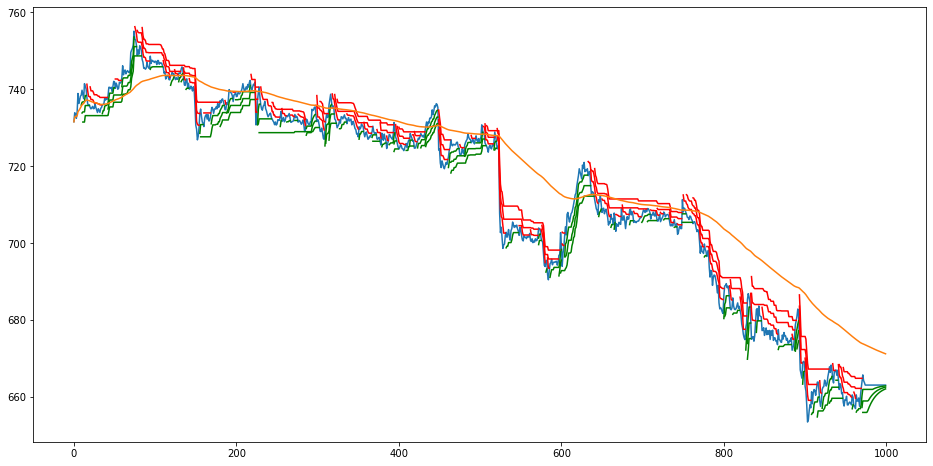

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy ADANIPORTS shares at 738.9
Sell ADANIPORTS at 747.75
Earning from investing 100k is 6.85 (ROI = 0.01%)
p:l(number)=1:0
success % =100.0%
Avg win=8.850000000000023
APOLLOHOSP


					APOLLOHOSP


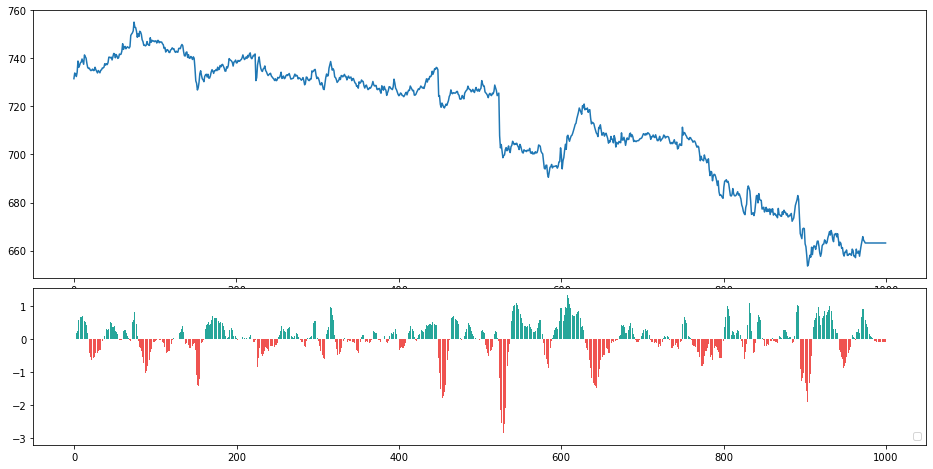

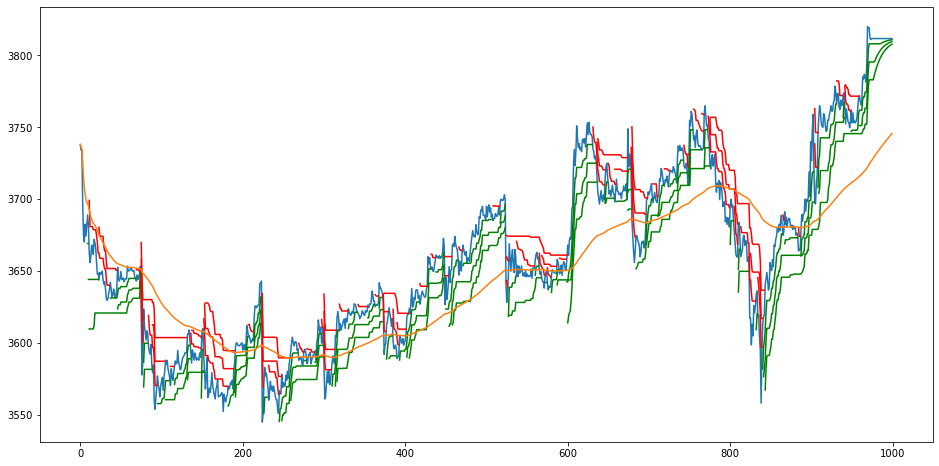

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy APOLLOHOSP shares at 3612.0
Sell APOLLOHOSP at 3602.0
Buy APOLLOHOSP shares at 3625.65
Sell APOLLOHOSP at 3545.0
Sell APOLLOHOSP at 3615.65
Buy APOLLOHOSP shares at 3616.0
Sell APOLLOHOSP at 3606.0
Buy APOLLOHOSP shares at 3611.15
Sell APOLLOHOSP at 3582.9
Sell APOLLOHOSP at 3601.15
Buy APOLLOHOSP shares at 3617.5
Sell APOLLOHOSP at 3592.1
Sell APOLLOHOSP at 3607.5
Buy APOLLOHOSP shares at 3629.0
Sell APOLLOHOSP at 3626.65
Buy APOLLOHOSP shares at 3668.75
Sell APOLLOHOSP at 3658.75
Buy APOLLOHOSP shares at 3673.7
Sell APOLLOHOSP at 3640.0
Sell APOLLOHOSP at 3663.7
Buy APOLLOHOSP shares at 3671.3
Sell APOLLOHOSP at 3705.0
Buy APOLLOHOSP shares at 3748.9
Sell APOLLOHOSP at 3738.9
Buy APOLLOHOSP shares at 3731.4
Sell APOLLOHOSP at 3721.4
Buy APOLLOHOSP shares at 3705.1
Sell APOLLOHOSP at 3720.95
Buy APOLLOHOSP shares at 3718.95
Sell APOLLOHOSP at 3708.95
Buy APOLLOHOSP shares at 3740.0
Sell APOLLOHOSP at 3730.0
Buy APOLLOHOSP shares at 3746.95
Sell APOLLOHOSP at 3736.95
Buy APOLLOHOSP

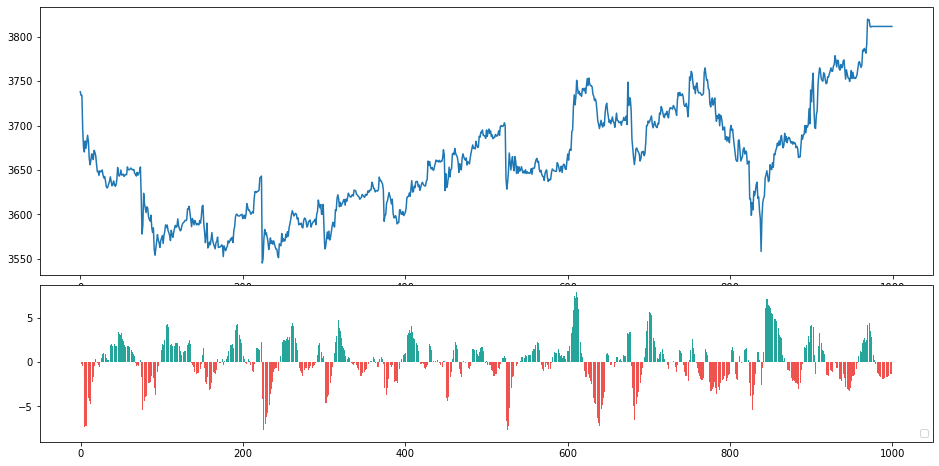

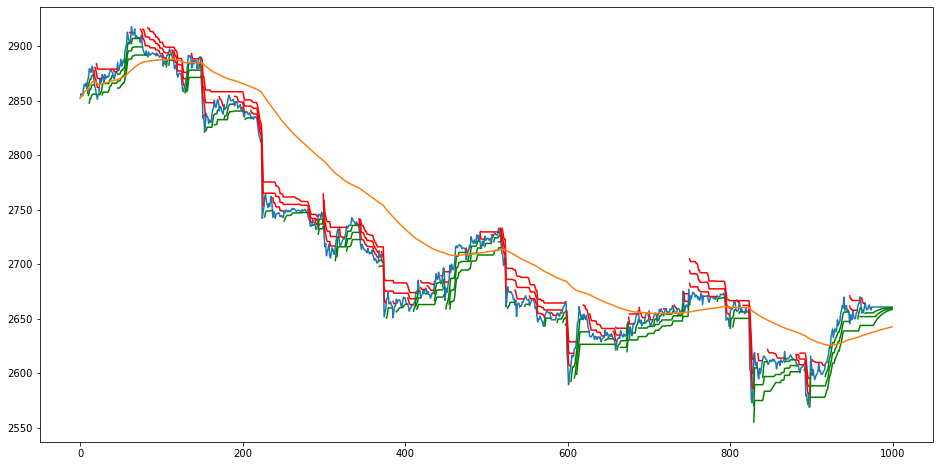

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy ASIANPAINT shares at 2861.15
Sell ASIANPAINT at 2854.95
Buy ASIANPAINT shares at 2888.0
Sell ASIANPAINT at 2890.0
Buy ASIANPAINT shares at 2677.0
Sell ASIANPAINT at 2662.7
Sell ASIANPAINT at 2667.0
Buy ASIANPAINT shares at 2648.95
Sell ASIANPAINTat 2660.7 
Earning from investing 100k is -16.75 (ROI = -0.02%)
p:l(number)=2:3
success % =40.0%
Avg win=6.875
Avg Loss=-10.166666666666819
AXISBANK


					AXISBANK


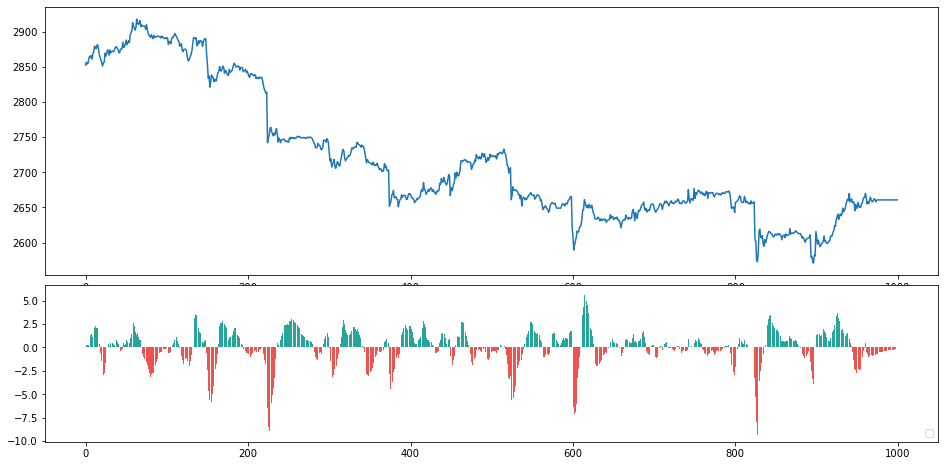

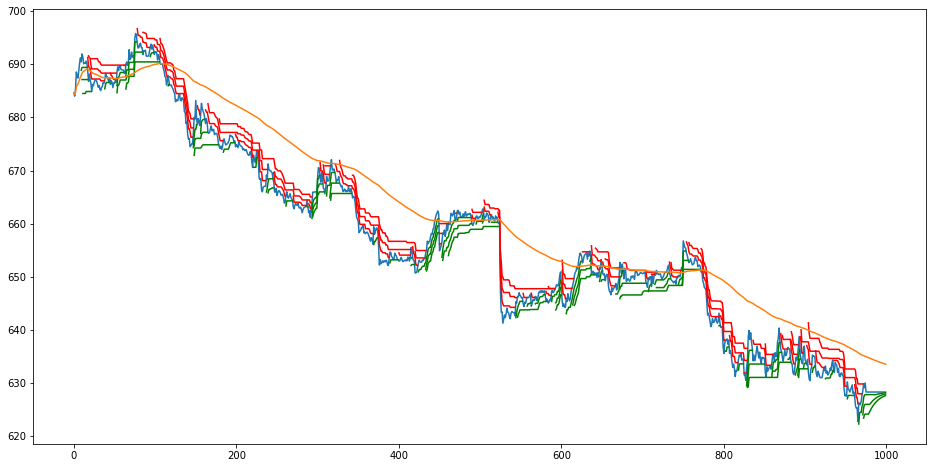

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy AXISBANK shares at 690.2
Sell AXISBANK at 684.85
Earning from investing 100k is -7.35 (ROI = -0.01%)
p:l(number)=0:1
success % =0.0%
Avg Loss=-5.350000000000023
BAJAJ-AUTO


					BAJAJ-AUTO


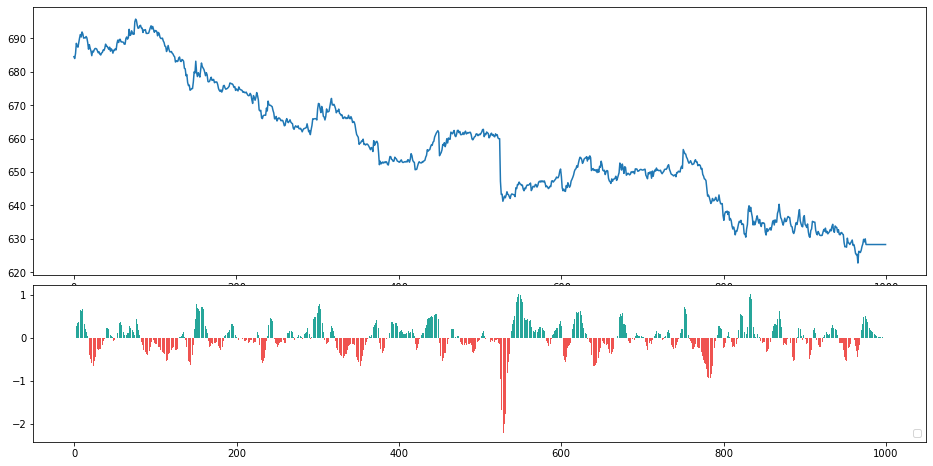

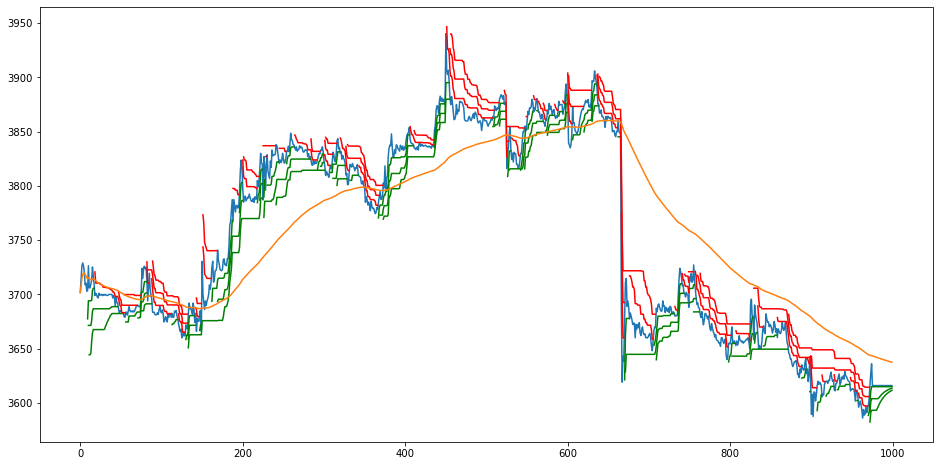

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy BAJAJ-AUTO shares at 3726.35
Sell BAJAJ-AUTO at 3716.35
Buy BAJAJ-AUTO shares at 3724.0
Sell BAJAJ-AUTO at 3714.0
Buy BAJAJ-AUTO shares at 3730.4
Sell BAJAJ-AUTO at 3720.4
Buy BAJAJ-AUTO shares at 3740.9
Sell BAJAJ-AUTO at 3730.9
Buy BAJAJ-AUTO shares at 3763.7
Sell BAJAJ-AUTO at 3787.0
Buy BAJAJ-AUTO shares at 3838.0
Sell BAJAJ-AUTO at 3828.0
Buy BAJAJ-AUTO shares at 3848.5
Sell BAJAJ-AUTO at 3838.5
Buy BAJAJ-AUTO shares at 3833.05
Sell BAJAJ-AUTO at 3823.05
Buy BAJAJ-AUTO shares at 3841.75
Sell BAJAJ-AUTO at 3831.75
Buy BAJAJ-AUTO shares at 3818.4
Sell BAJAJ-AUTO at 3808.4
Buy BAJAJ-AUTO shares at 3826.5
Sell BAJAJ-AUTO at 3874.9
Buy BAJAJ-AUTO shares at 3879.55
Sell BAJAJ-AUTO at 3816.05
Sell BAJAJ-AUTO at 3869.55
Buy BAJAJ-AUTO shares at 3868.65
Sell BAJAJ-AUTO at 3858.65
Buy BAJAJ-AUTO shares at 3875.0
Sell BAJAJ-AUTO at 3839.7
Sell BAJAJ-AUTO at 3865.0
Buy BAJAJ-AUTO shares at 3896.9
Sell BAJAJ-AUTO at 3886.9
Earning from investing 100k is -171.1 (ROI = -0.17%)
p:l(number)=2:

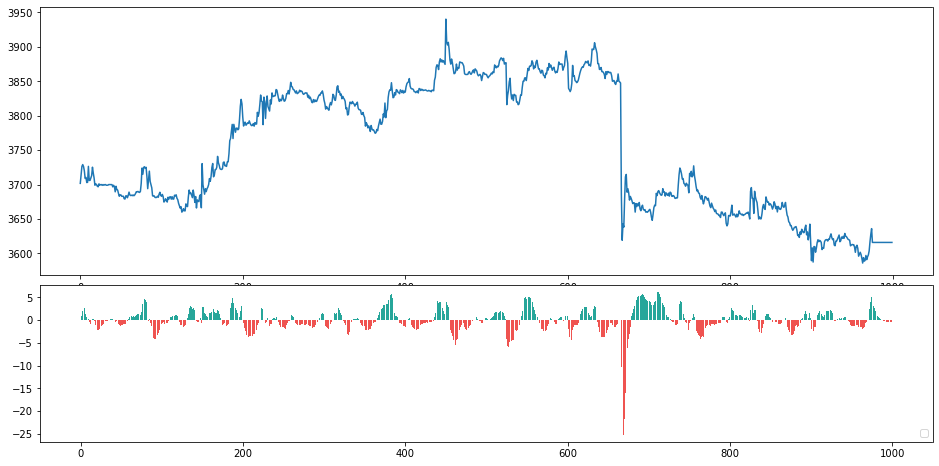

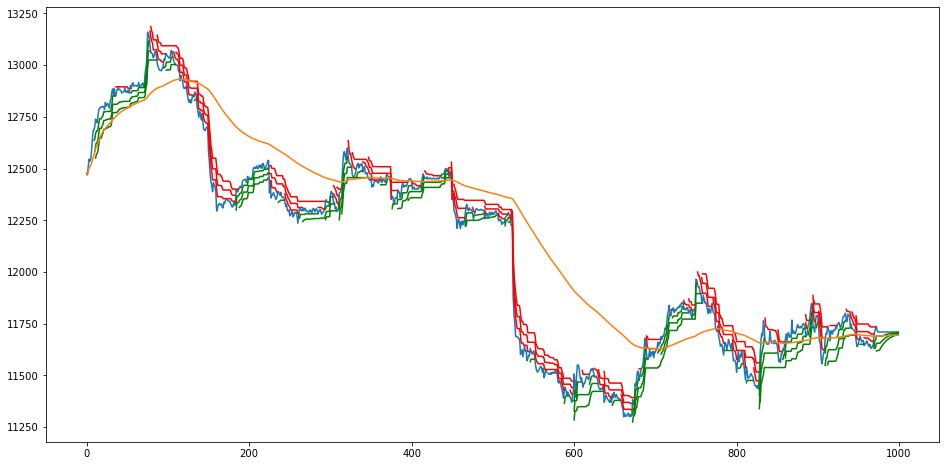

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy BAJAJFINSV shares at 12513.25
Sell BAJAJFINSV at 13005.0
Buy BAJAJFINSV shares at 12501.85
Sell BAJAJFINSV at 12491.85
Buy BAJAJFINSV shares at 12474.3
Sell BAJAJFINSV at 12464.3
Buy BAJAJFINSV shares at 12474.3
Sell BAJAJFINSV at 12464.3
Buy BAJAJFINSV shares at 11679.0
Sell BAJAJFINSV at 11669.0
Buy BAJAJFINSV shares at 11704.35
Sell BAJAJFINSV at 11847.9
Buy BAJAJFINSV shares at 11704.0
Sell BAJAJFINSV at 11694.0
Buy BAJAJFINSV shares at 11763.75
Sell BAJAJFINSV at 11753.75
Buy BAJAJFINSV shares at 11700.0
Sell BAJAJFINSV at 11690.0
Buy BAJAJFINSV shares at 11702.0
Sell BAJAJFINSV at 11692.0
Buy BAJAJFINSV shares at 11692.25
Sell BAJAJFINSV at 11728.05
Buy BAJAJFINSV shares at 11738.0
Sell BAJAJFINSV at 11728.0
Buy BAJAJFINSV shares at 11711.0
Sell BAJAJFINSV at 11701.0
Buy BAJAJFINSV shares at 11748.0
Sell BAJAJFINSV at 11738.0
Buy BAJAJFINSV shares at 11744.0
Sell BAJAJFINSV at 11734.0
Buy BAJAJFINSV shares at 11737.25
Sell BAJAJFINSV at 11727.25
Earning from investing 100k is

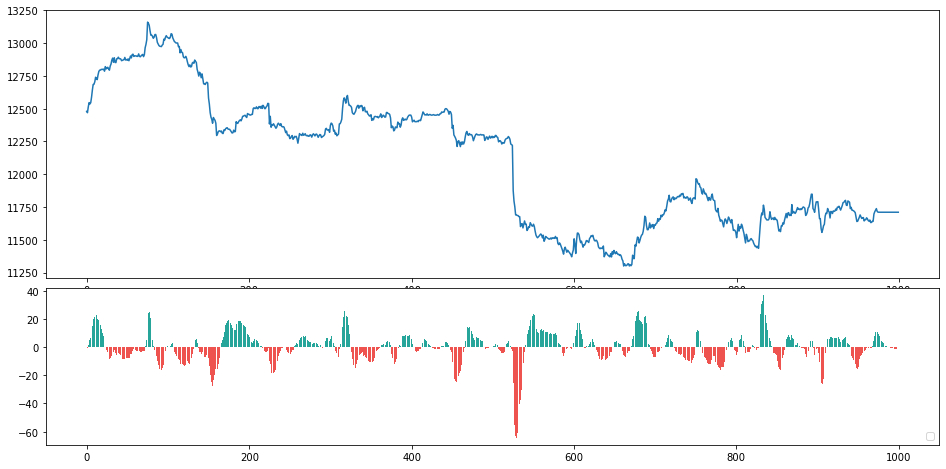

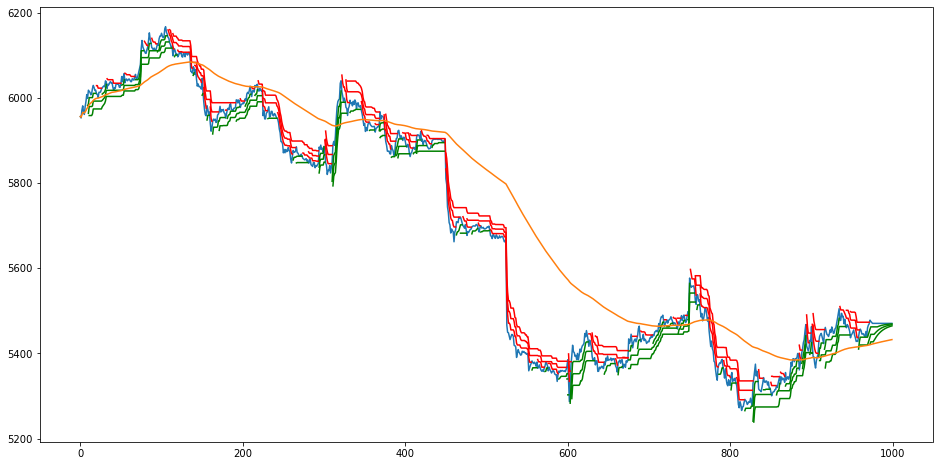

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy BAJFINANCE shares at 5971.0
Sell BAJFINANCE at 6098.75
Buy BAJFINANCE shares at 5977.5
Sell BAJFINANCE at 5958.6
Sell BAJFINANCE at 5967.5
Buy BAJFINANCE shares at 5967.0
Sell BAJFINANCE at 5957.0
Buy BAJFINANCE shares at 5485.55
Sell BAJFINANCE at 5475.55
Buy BAJFINANCE shares at 5489.95
Sell BAJFINANCE at 5479.95
Buy BAJFINANCE shares at 5498.0
Sell BAJFINANCE at 5515.2
Buy BAJFINANCE shares at 5410.5
Sell BAJFINANCE at 5392.8
Sell BAJFINANCE at 5400.5
Buy BAJFINANCE shares at 5461.0
Sell BAJFINANCE at 5451.0
Buy BAJFINANCE shares at 5443.05
Sell BAJFINANCE at 5436.65
Buy BAJFINANCE shares at 5477.95
Sell BAJFINANCEat 5470.45 
Earning from investing 100k is 30.45 (ROI = 0.03%)
p:l(number)=2:10
success % =16.666666666666664%
Avg win=72.47499999999991
Avg Loss=-11.05
BPCL


					BPCL


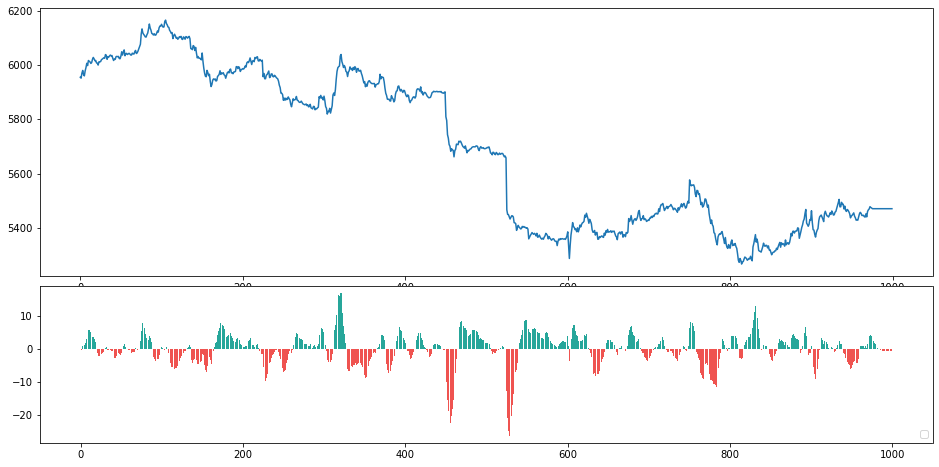

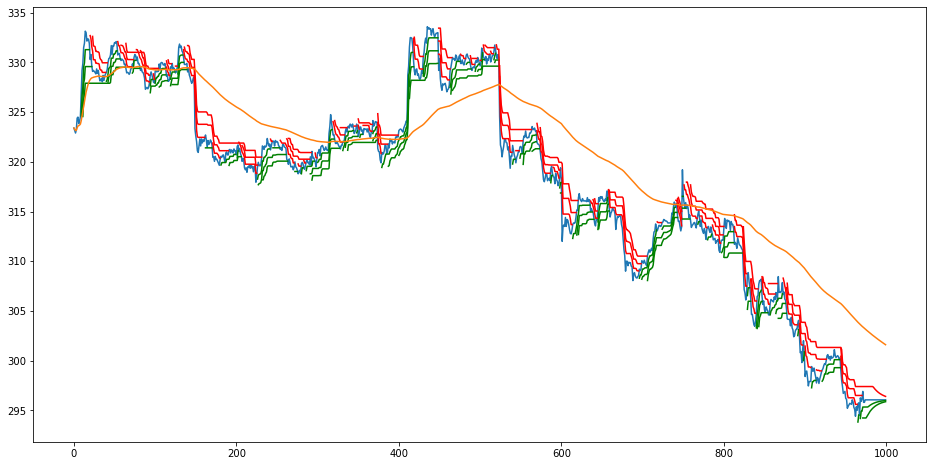

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy BPCL shares at 329.2
Sell BPCL at 329.4
Earning from investing 100k is -1.8 (ROI = -0.0%)
p:l(number)=1:0
success % =100.0%
Avg win=0.19999999999998863
BHARTIARTL


					BHARTIARTL


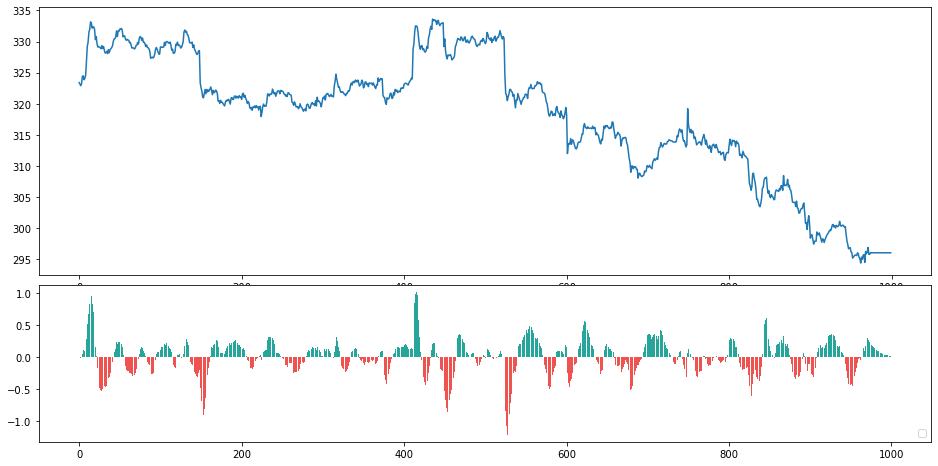

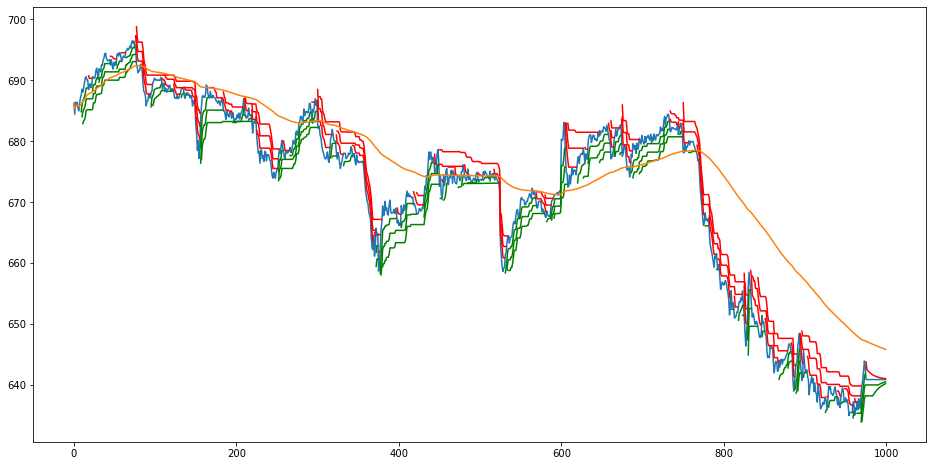

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Earning from investing 100k is 0 (ROI = 0.0%)
p:l(number)=0:0
success % =0%
BRITANNIA


					BRITANNIA


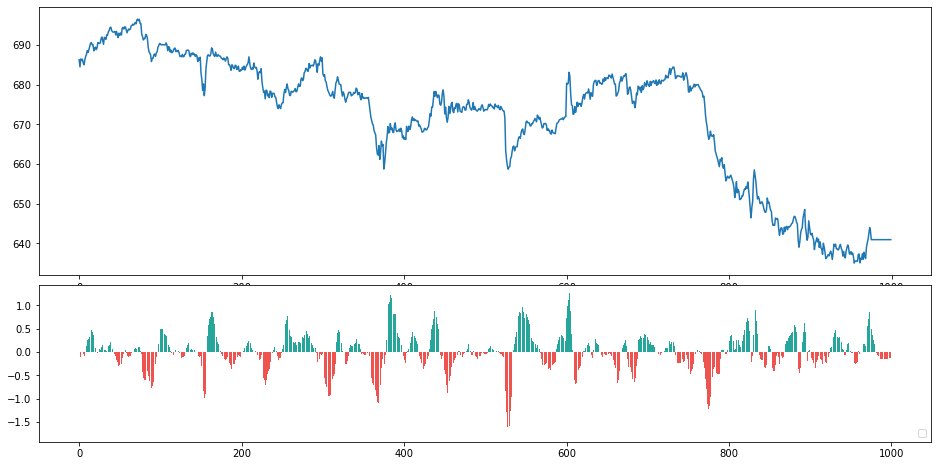

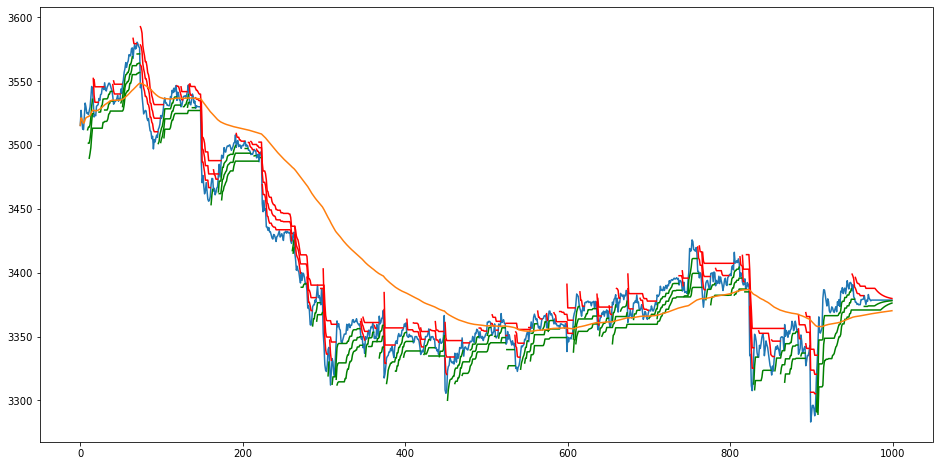

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy BRITANNIA shares at 3532.9
Sell BRITANNIA at 3522.9
Buy BRITANNIA shares at 3548.8
Sell BRITANNIA at 3538.8
Buy BRITANNIA shares at 3550.9
Sell BRITANNIA at 3544.95
Buy BRITANNIA shares at 3383.4
Sell BRITANNIA at 3373.4
Buy BRITANNIA shares at 3382.8
Sell BRITANNIA at 3372.8
Buy BRITANNIA shares at 3383.85
Sell BRITANNIA at 3373.85
Buy BRITANNIA shares at 3389.45
Sell BRITANNIA at 3380.05
Buy BRITANNIA shares at 3416.05
Sell BRITANNIA at 3406.05
Buy BRITANNIA shares at 3379.65
Sell BRITANNIA at 3369.65
Earning from investing 100k is -103.35 (ROI = -0.1%)
p:l(number)=0:9
success % =0.0%
Avg Loss=-9.483333333333324
CIPLA


					CIPLA


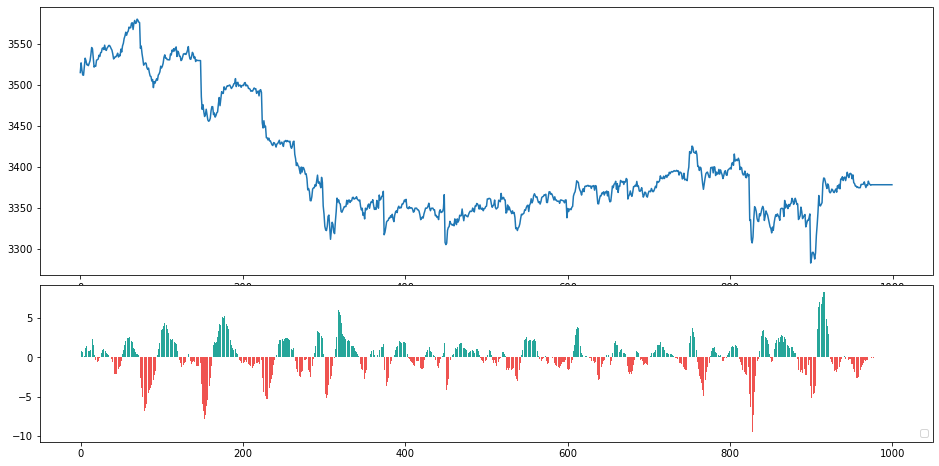

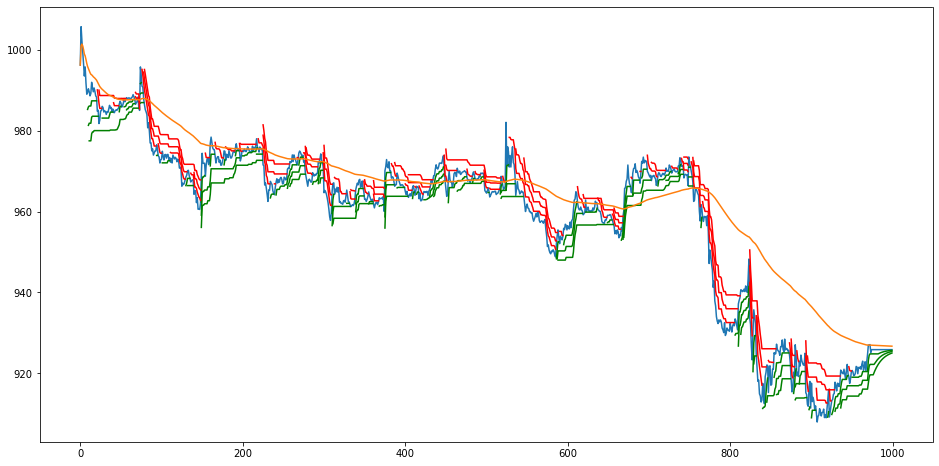

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy CIPLA shares at 1002.25
Sell CIPLA at 992.25
Earning from investing 100k is -12.0 (ROI = -0.01%)
p:l(number)=0:1
success % =0.0%
Avg Loss=-10.0
COALINDIA


					COALINDIA


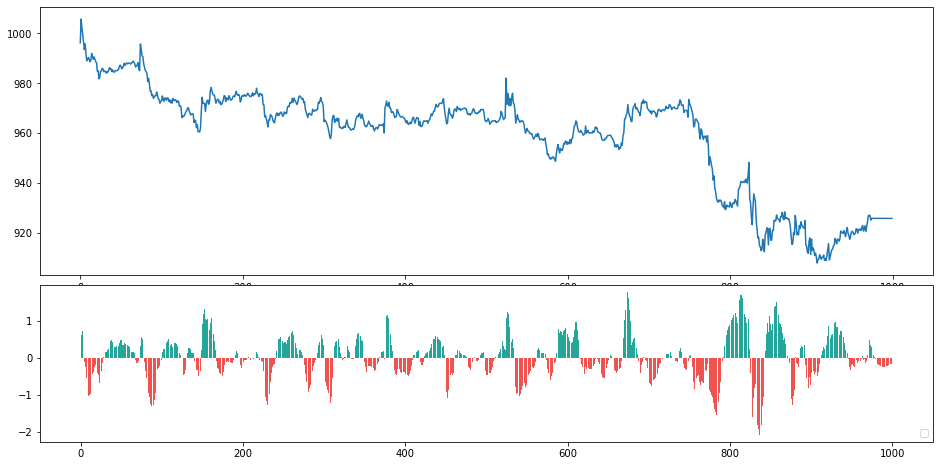

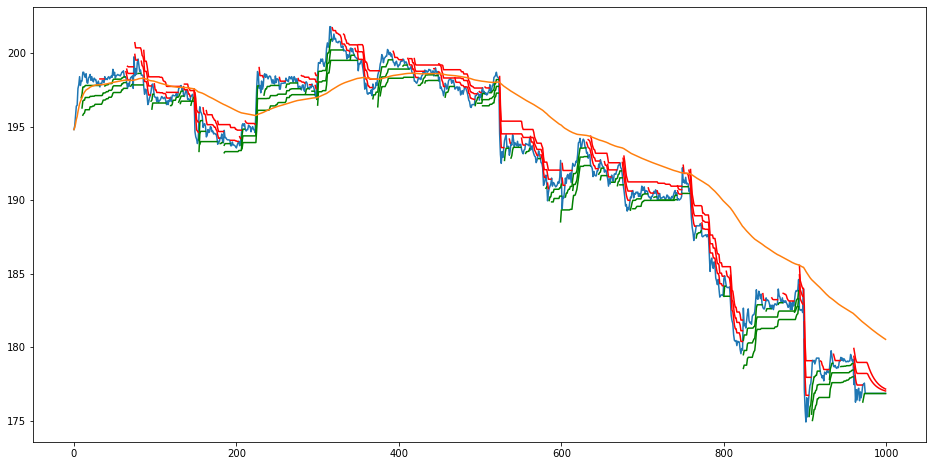

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Earning from investing 100k is 0 (ROI = 0.0%)
p:l(number)=0:0
success % =0%
DRREDDY


					DRREDDY


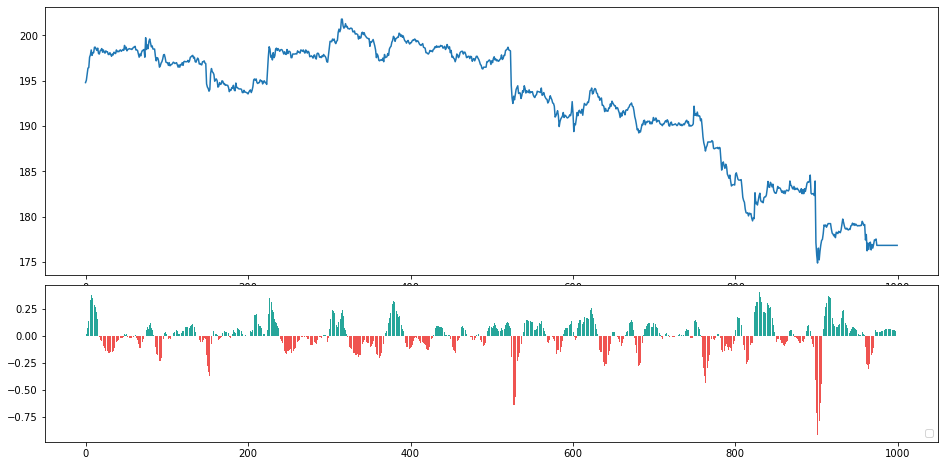

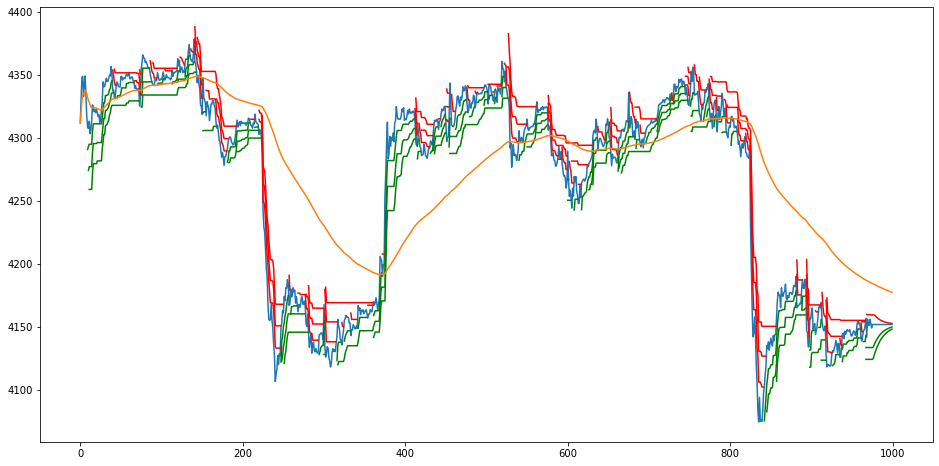

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy DRREDDY shares at 4348.0
Sell DRREDDY at 4338.0
Buy DRREDDY shares at 4343.2
Sell DRREDDY at 4333.2
Buy DRREDDY shares at 4344.65
Sell DRREDDY at 4334.65
Buy DRREDDY shares at 4360.0
Sell DRREDDY at 4350.0
Buy DRREDDY shares at 4363.0
Sell DRREDDY at 4353.0
Buy DRREDDY shares at 4362.7
Sell DRREDDY at 4352.7
Buy DRREDDY shares at 4253.75
Sell DRREDDY at 4296.45
Buy DRREDDY shares at 4314.0
Sell DRREDDY at 4297.35
Sell DRREDDY at 4304.0
Buy DRREDDY shares at 4343.7
Sell DRREDDY at 4333.7
Buy DRREDDY shares at 4333.0
Sell DRREDDY at 4323.0
Buy DRREDDY shares at 4342.2
Sell DRREDDY at 4332.2
Buy DRREDDY shares at 4360.75
Sell DRREDDY at 4350.75
Buy DRREDDY shares at 4328.8
Sell DRREDDY at 4306.3
Sell DRREDDY at 4318.8
Buy DRREDDY shares at 4315.0
Sell DRREDDY at 4305.0
Buy DRREDDY shares at 4315.25
Sell DRREDDY at 4305.25
Buy DRREDDY shares at 4313.75
Sell DRREDDY at 4303.75
Buy DRREDDY shares at 4320.0
Sell DRREDDY at 4327.05
Buy DRREDDY shares at 4356.45
Sell DRREDDY at 4346.45
Buy 

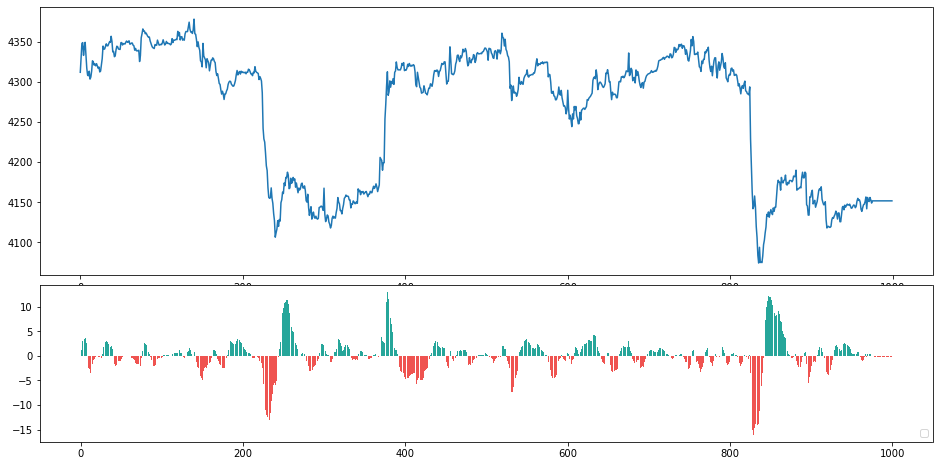

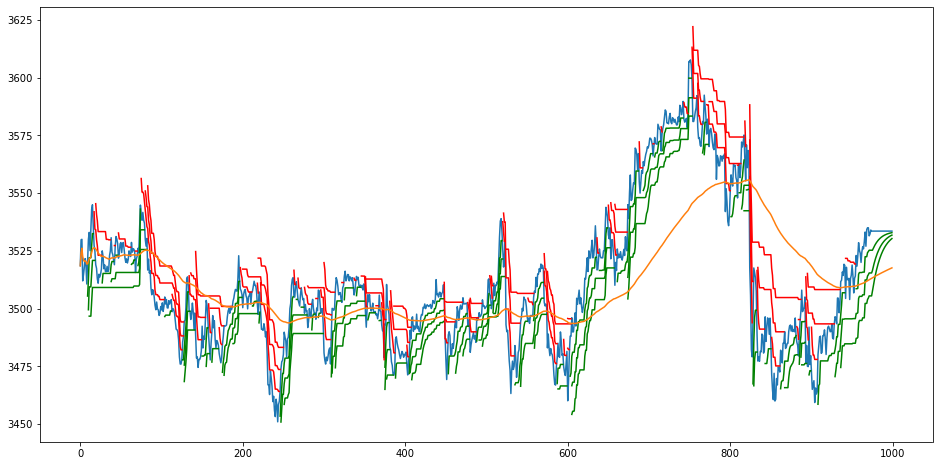

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy DIVISLAB shares at 3530.0
Sell DIVISLAB at 3520.0
Buy DIVISLAB shares at 3533.0
Sell DIVISLAB at 3523.0
Buy DIVISLAB shares at 3530.7
Sell DIVISLAB at 3520.7
Buy DIVISLAB shares at 3531.2
Sell DIVISLAB at 3521.2
Buy DIVISLAB shares at 3535.0
Sell DIVISLAB at 3516.7
Sell DIVISLAB at 3525.0
Buy DIVISLAB shares at 3522.9
Sell DIVISLAB at 3512.9
Buy DIVISLAB shares at 3512.8
Sell DIVISLAB at 3502.8
Buy DIVISLAB shares at 3520.4
Sell DIVISLAB at 3493.0
Sell DIVISLAB at 3510.4
Buy DIVISLAB shares at 3519.3
Sell DIVISLAB at 3509.3
Buy DIVISLAB shares at 3517.0
Sell DIVISLAB at 3510.1
Buy DIVISLAB shares at 3545.0
Sell DIVISLAB at 3581.0
Buy DIVISLAB shares at 3575.15
Sell DIVISLAB at 3565.15
Earning from investing 100k is -124.6 (ROI = -0.12%)
p:l(number)=1:13
success % =7.142857142857142%
Avg win=36.0
Avg Loss=-11.738461538461566
GRASIM


					GRASIM


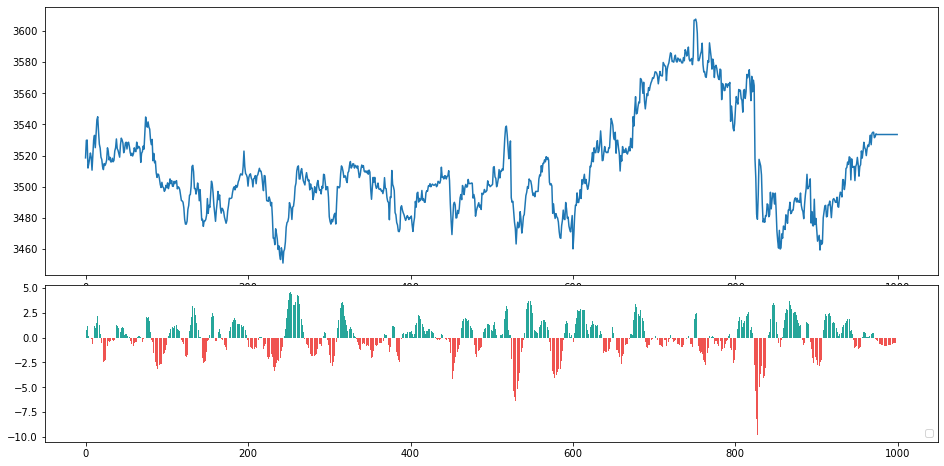

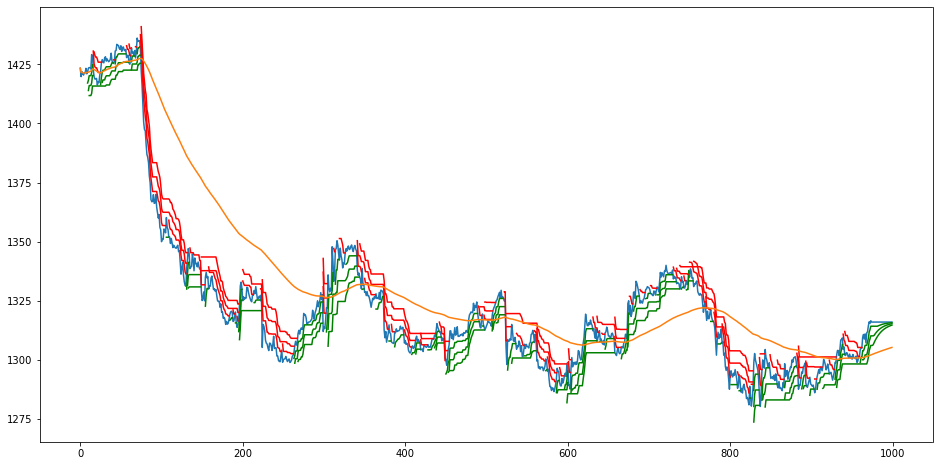

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy GRASIM shares at 1429.1
Sell GRASIM at 1419.1
Buy GRASIM shares at 1427.0
Sell GRASIM at 1422.25
Buy GRASIM shares at 1347.85
Sell GRASIM at 1337.85
Buy GRASIM shares at 1346.65
Sell GRASIM at 1336.65
Buy GRASIM shares at 1328.65
Sell GRASIM at 1329.9
Earning from investing 100k is -43.5 (ROI = -0.04%)
p:l(number)=1:4
success % =20.0%
Avg win=1.25
Avg Loss=-8.6875
HCLTECH


					HCLTECH


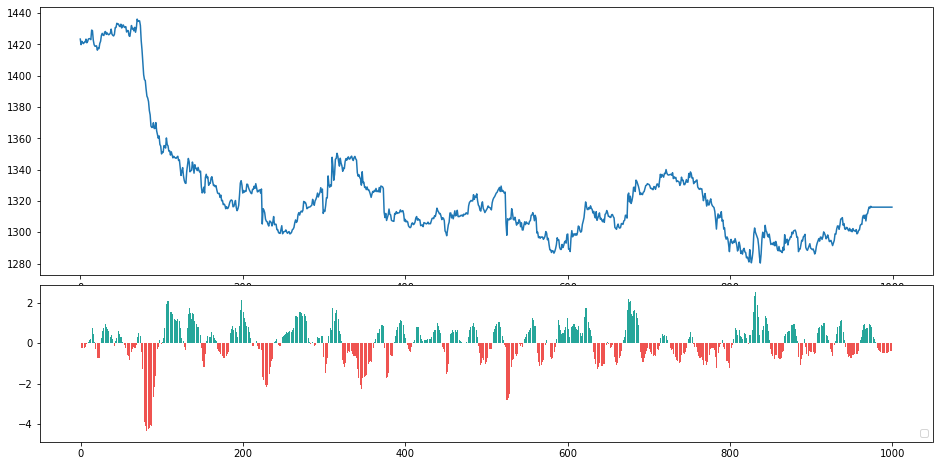

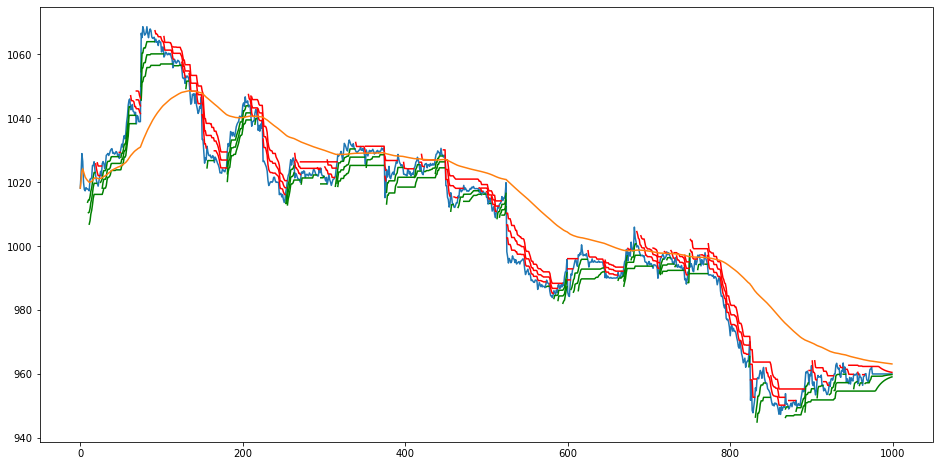

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy HCLTECH shares at 1029.0
Sell HCLTECH at 1019.0
Buy HCLTECH shares at 1025.25
Sell HCLTECH at 1038.3
Buy HCLTECH shares at 1066.65
Sell HCLTECH at 1055.85
Sell HCLTECH at 1056.65
Earning from investing 100k is -15.75 (ROI = -0.02%)
p:l(number)=1:3
success % =25.0%
Avg win=13.049999999999955
Avg Loss=-10.266666666666728
HDFC


					HDFC


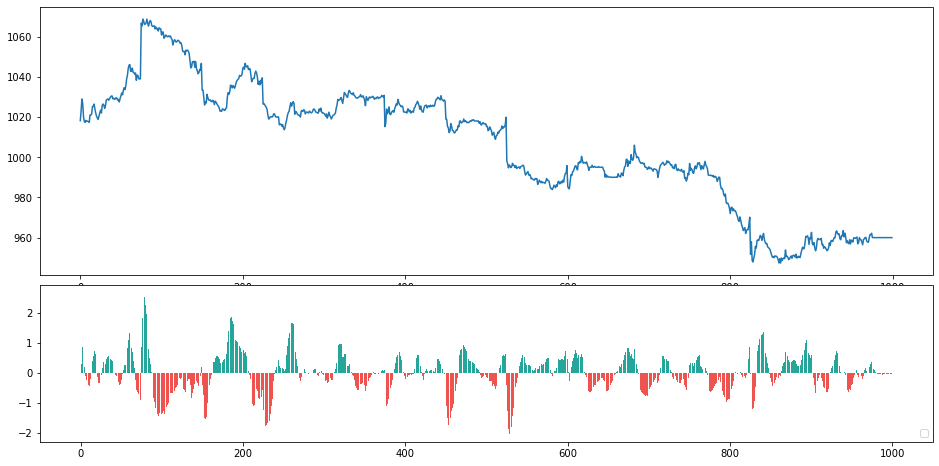

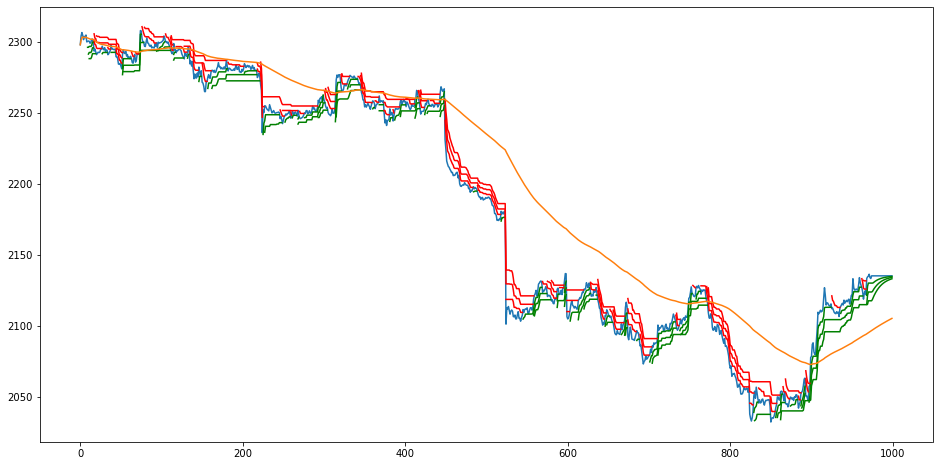

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy HDFC shares at 2306.6
Sell HDFC at 2296.6
Buy HDFC shares at 2308.0
Sell HDFC at 2298.0
Buy HDFC shares at 2097.55
Sell HDFCat 2135.25 
Earning from investing 100k is 11.7 (ROI = 0.01%)
p:l(number)=1:2
success % =33.33333333333333%
Avg win=37.69999999999982
Avg Loss=-10.0
HDFCBANK


					HDFCBANK


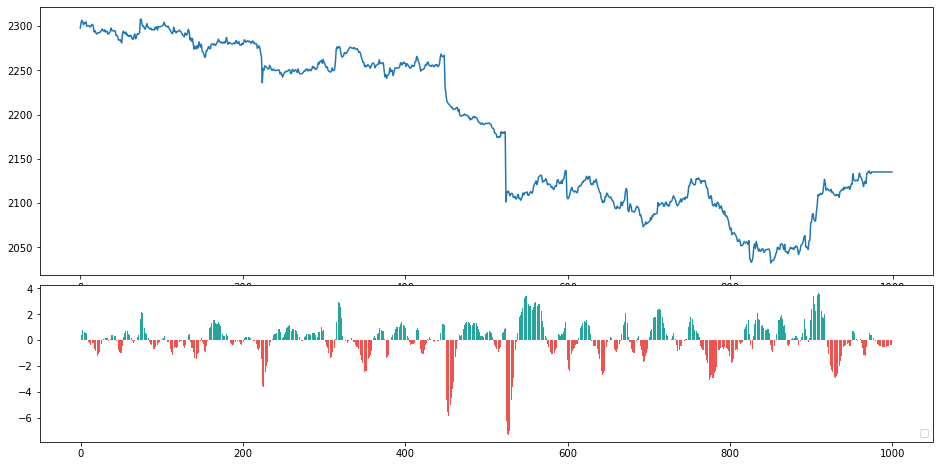

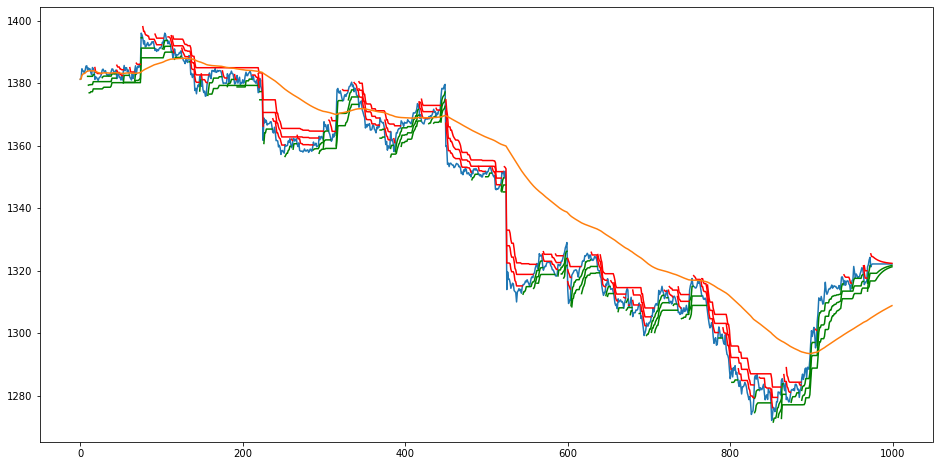

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy HDFCBANK shares at 1396.0
Sell HDFCBANK at 1388.05
Earning from investing 100k is -9.95 (ROI = -0.01%)
p:l(number)=0:1
success % =0.0%
Avg Loss=-7.9500000000000455
HDFCLIFE


					HDFCLIFE


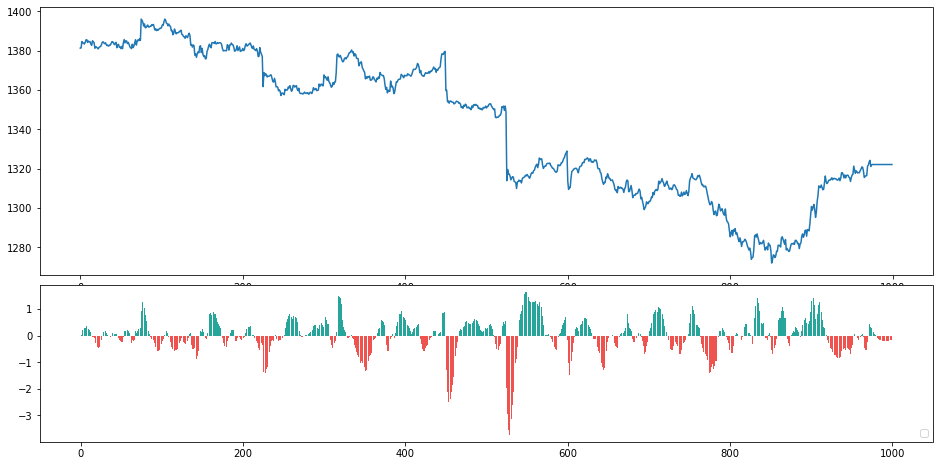

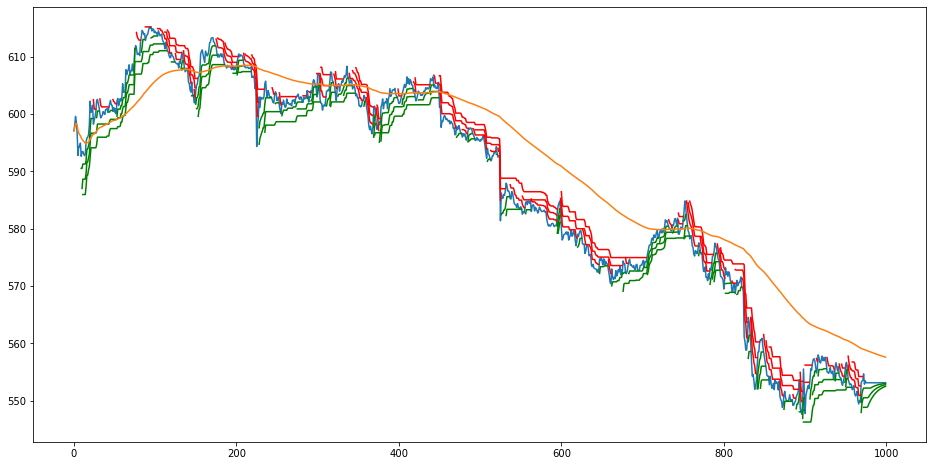

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy HDFCLIFE shares at 602.25
Sell HDFCLIFE at 611.0
Earning from investing 100k is 6.75 (ROI = 0.01%)
p:l(number)=1:0
success % =100.0%
Avg win=8.75
HEROMOTOCO


					HEROMOTOCO


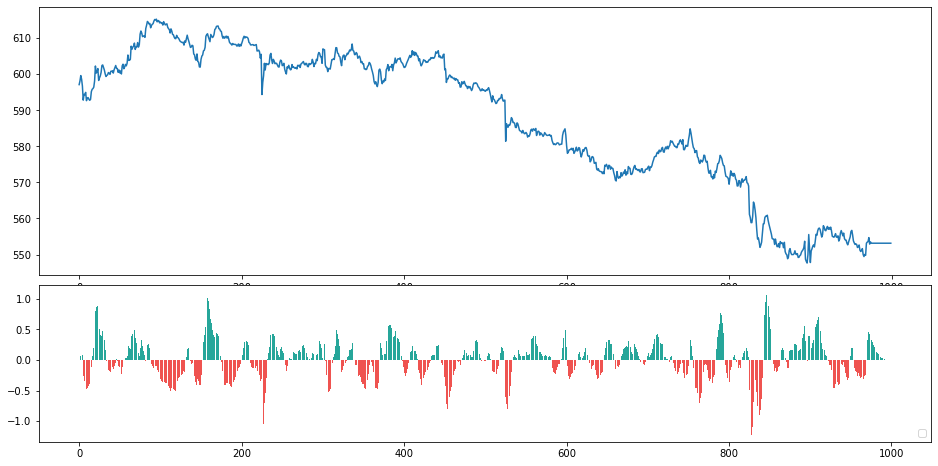

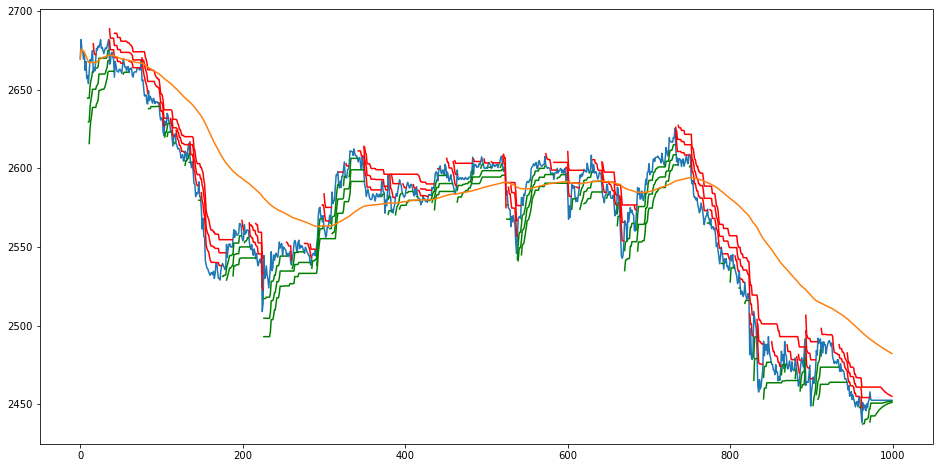

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy HEROMOTOCO shares at 2675.0
Sell HEROMOTOCO at 2665.0
Buy HEROMOTOCO shares at 2676.4
Sell HEROMOTOCO at 2666.4
Buy HEROMOTOCO shares at 2585.0
Sell HEROMOTOCO at 2589.5
Buy HEROMOTOCO shares at 2601.65
Sell HEROMOTOCO at 2591.65
Buy HEROMOTOCO shares at 2607.15
Sell HEROMOTOCO at 2597.15
Buy HEROMOTOCO shares at 2607.35
Sell HEROMOTOCO at 2583.3
Sell HEROMOTOCO at 2597.35
Buy HEROMOTOCO shares at 2606.2
Sell HEROMOTOCO at 2601.8
Earning from investing 100k is -79.95 (ROI = -0.08%)
p:l(number)=1:7
success % =12.5%
Avg win=4.5
Avg Loss=-11.207142857142767
HINDALCO


					HINDALCO


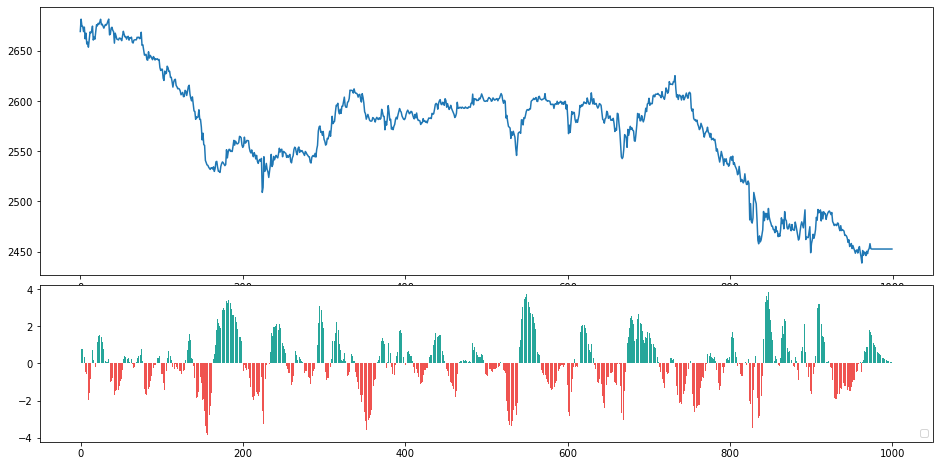

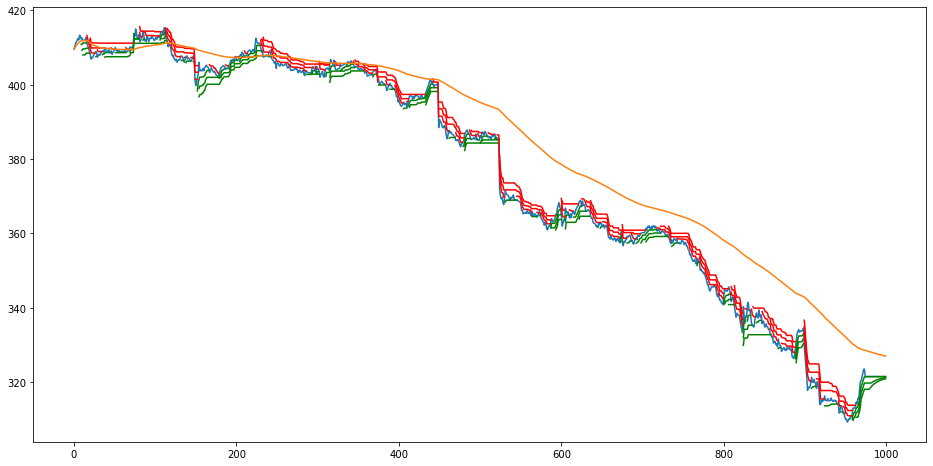

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Earning from investing 100k is 0 (ROI = 0.0%)
p:l(number)=0:0
success % =0%
HINDUNILVR


					HINDUNILVR


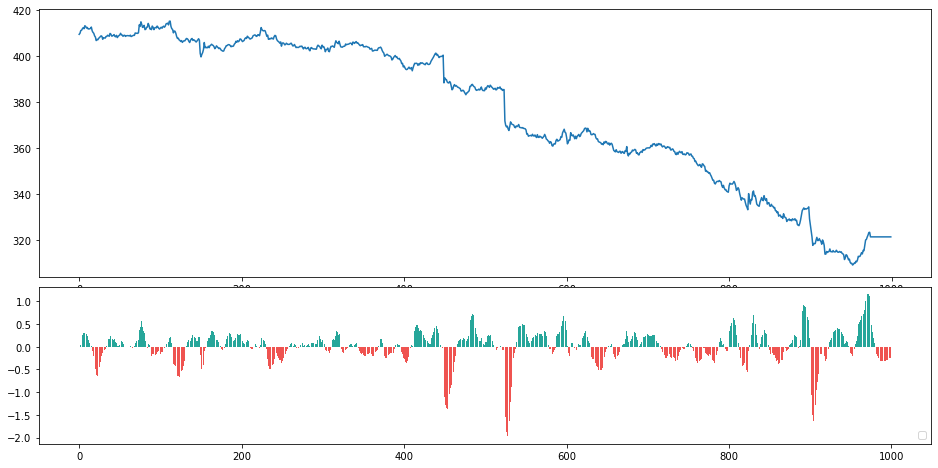

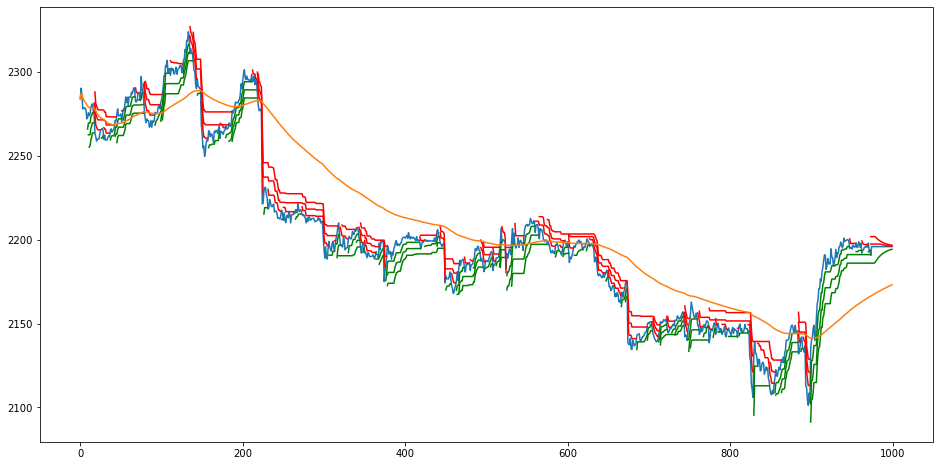

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy HINDUNILVR shares at 2278.0
Sell HINDUNILVR at 2272.05
Buy HINDUNILVR shares at 2290.35
Sell HINDUNILVR at 2306.65
Buy HINDUNILVR shares at 2298.95
Sell HINDUNILVR at 2288.95
Buy HINDUNILVR shares at 2164.25
Sell HINDUNILVRat 2195.9 
Earning from investing 100k is 24.0 (ROI = 0.02%)
p:l(number)=2:2
success % =50.0%
Avg win=23.975000000000136
Avg Loss=-7.974999999999909
ICICIBANK


					ICICIBANK


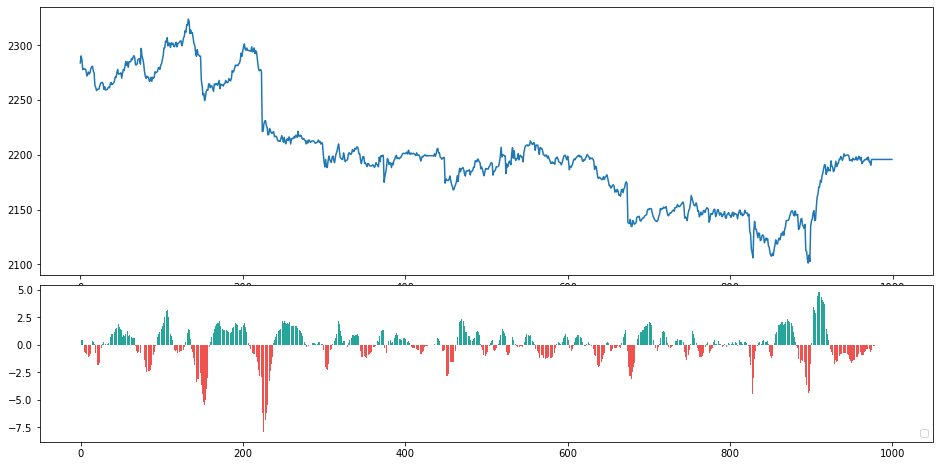

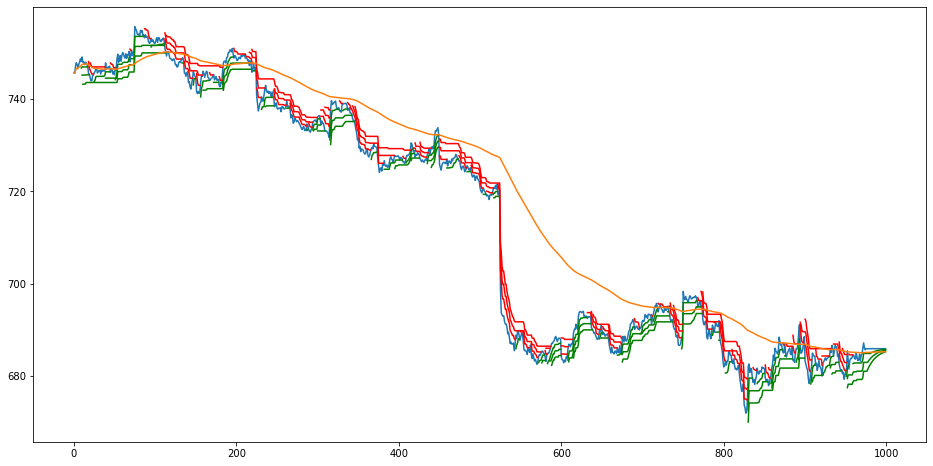

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Earning from investing 100k is 0 (ROI = 0.0%)
p:l(number)=0:0
success % =0%
ITC


					ITC


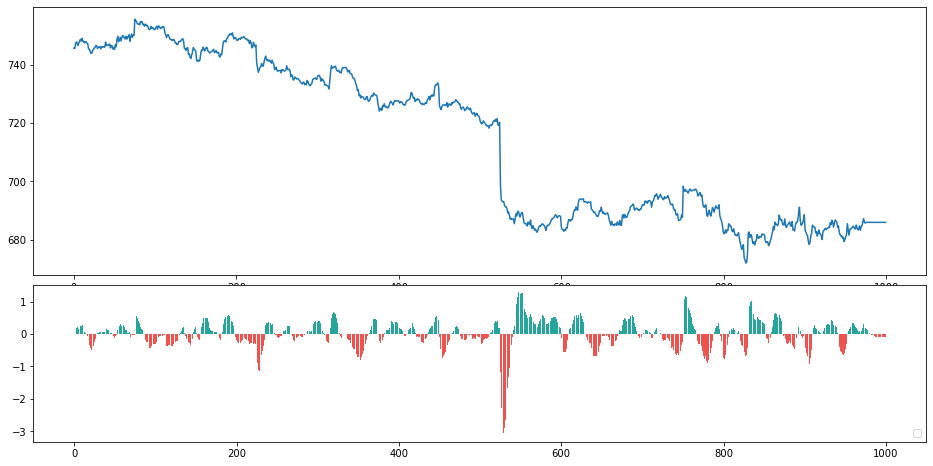

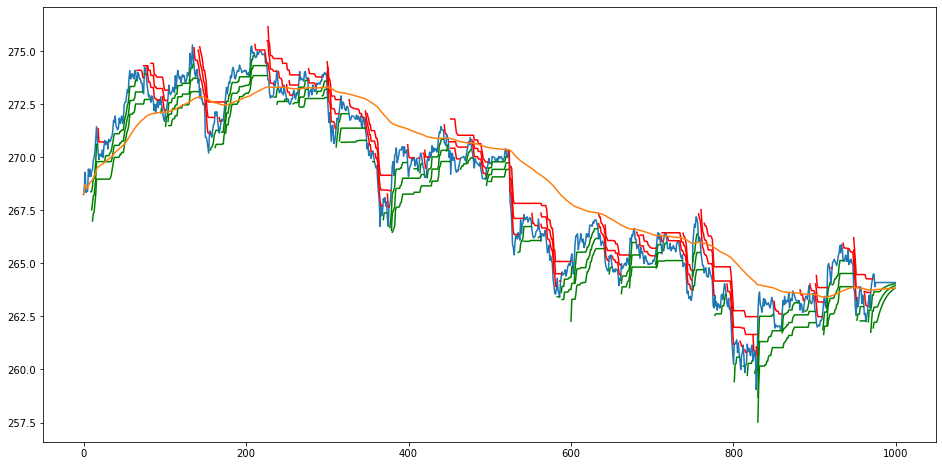

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Earning from investing 100k is 0 (ROI = 0.0%)
p:l(number)=0:0
success % =0%
INDUSINDBK


					INDUSINDBK


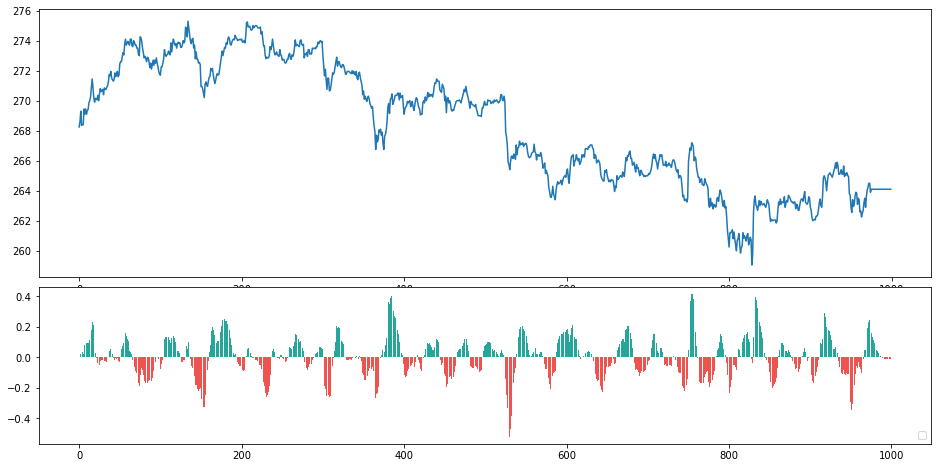

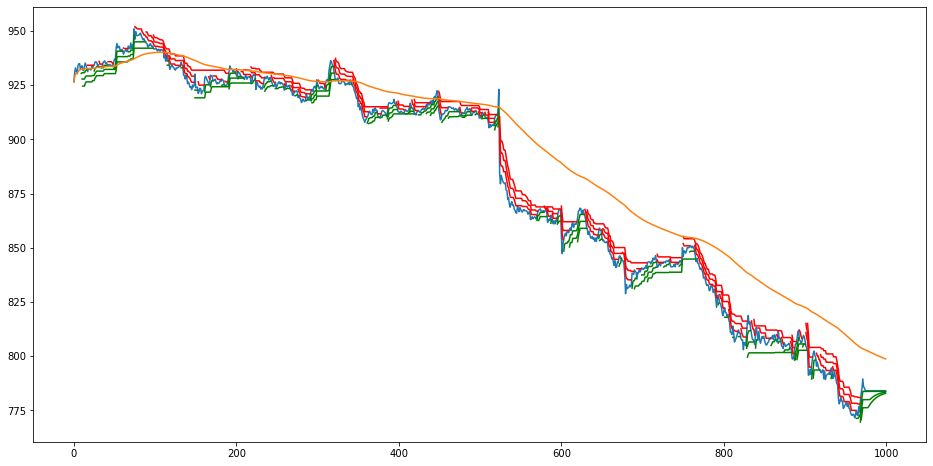

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy INDUSINDBK shares at 933.0
Sell INDUSINDBK at 941.8
Earning from investing 100k is 6.8 (ROI = 0.01%)
p:l(number)=1:0
success % =100.0%
Avg win=8.799999999999955
INFY


					INFY


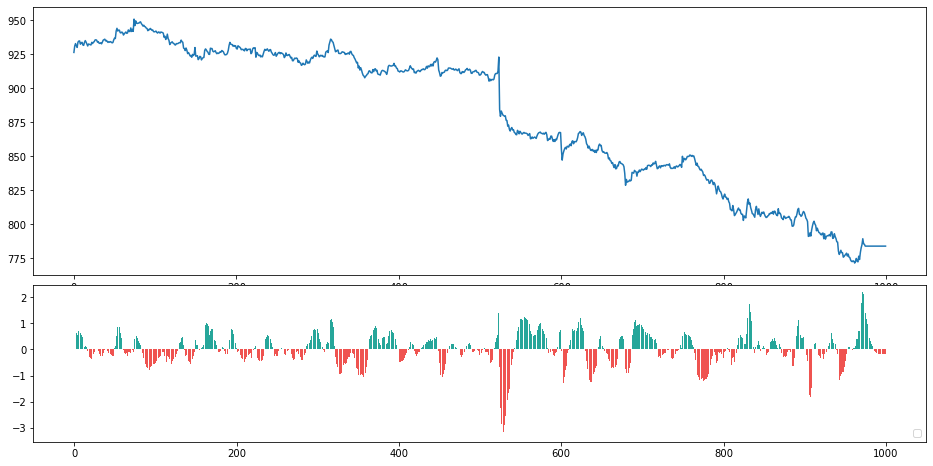

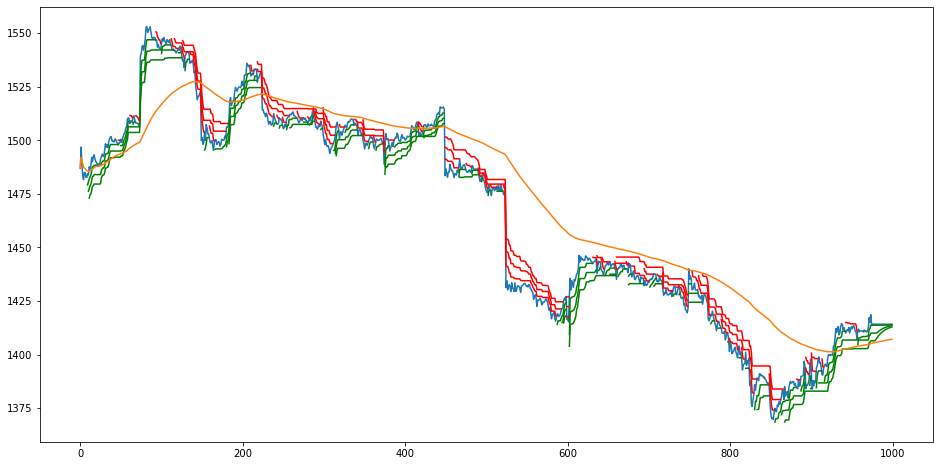

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy INFY shares at 1492.0
Sell INFY at 1537.0
Earning from investing 100k is 43.0 (ROI = 0.04%)
p:l(number)=1:0
success % =100.0%
Avg win=45.0
JSWSTEEL


					JSWSTEEL


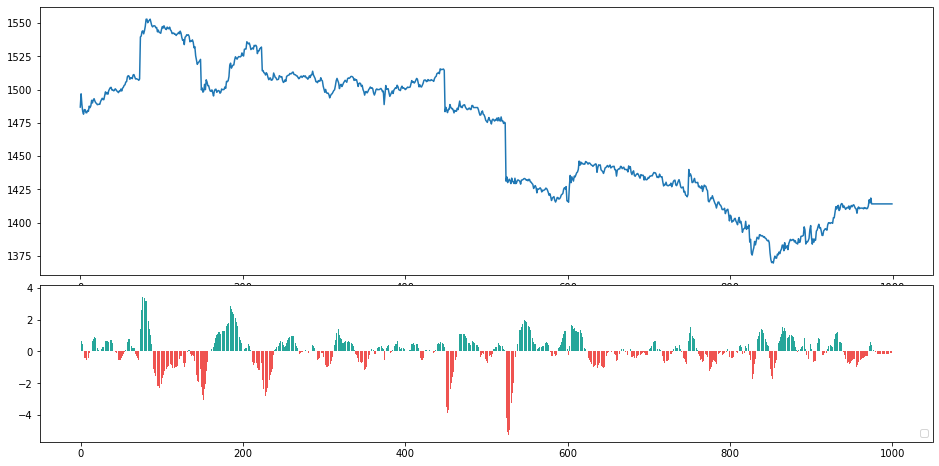

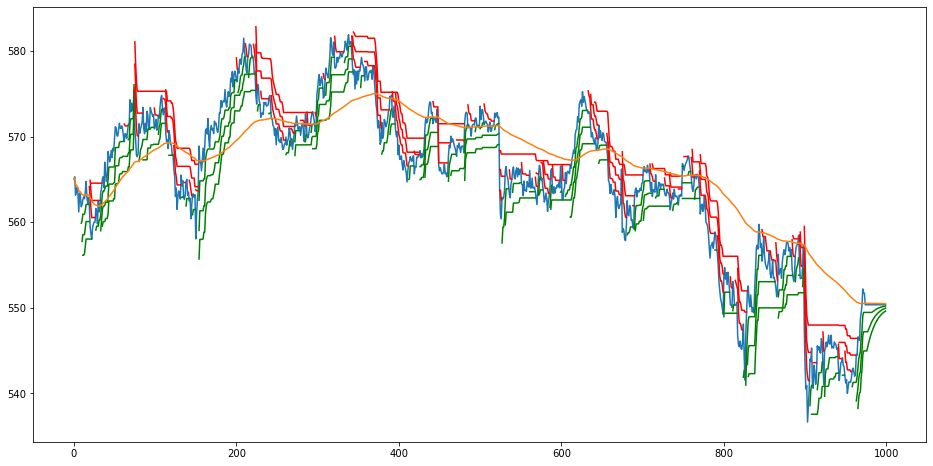

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Earning from investing 100k is 0 (ROI = 0.0%)
p:l(number)=0:0
success % =0%
KOTAKBANK


					KOTAKBANK


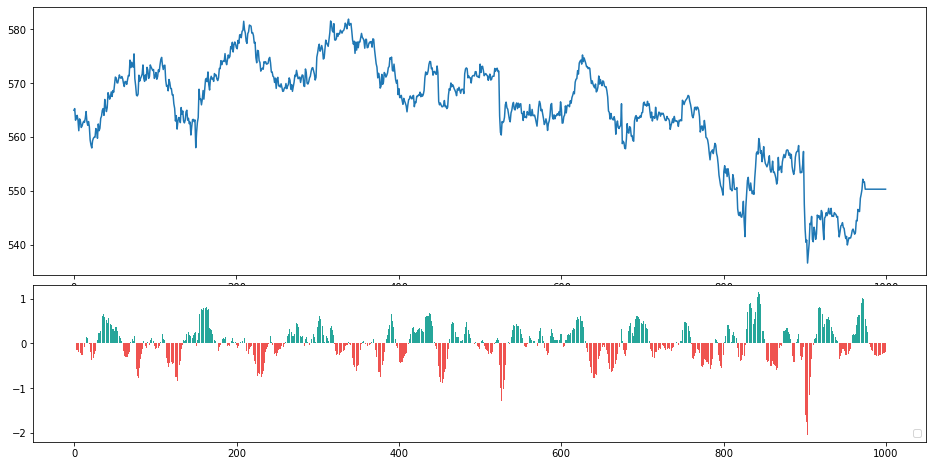

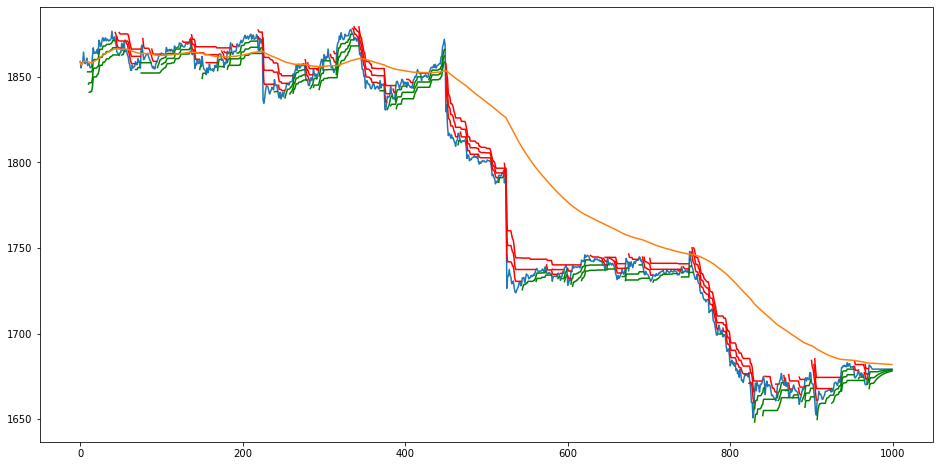

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy KOTAKBANK shares at 1867.0
Sell KOTAKBANK at 1862.5
Earning from investing 100k is -6.5 (ROI = -0.01%)
p:l(number)=0:1
success % =0.0%
Avg Loss=-4.5
LT


					LT


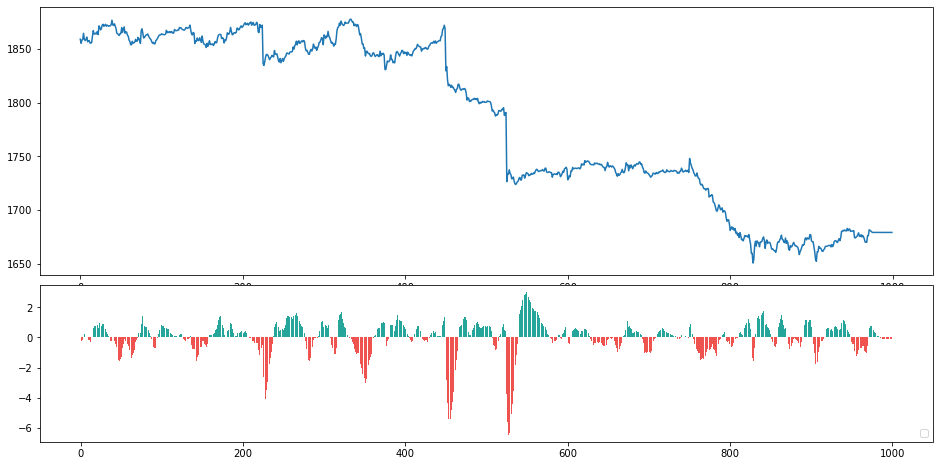

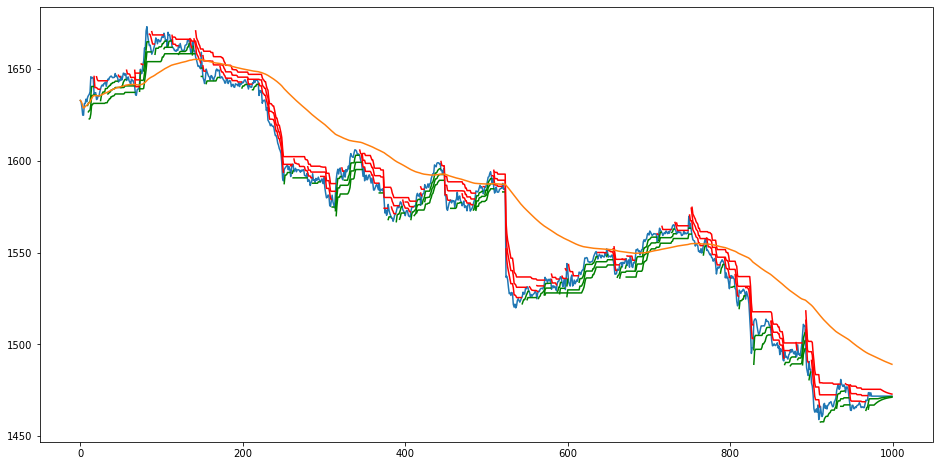

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy LT shares at 1635.45
Sell LT at 1635.9
Buy LT shares at 1654.1
Sell LT at 1656.35
Earning from investing 100k is -1.3 (ROI = -0.0%)
p:l(number)=2:0
success % =100.0%
Avg win=1.3500000000000227
M&M


					M&M


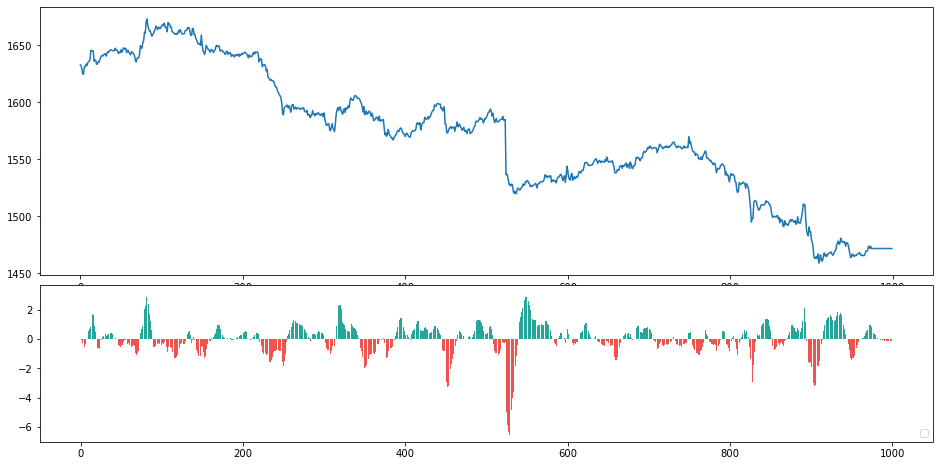

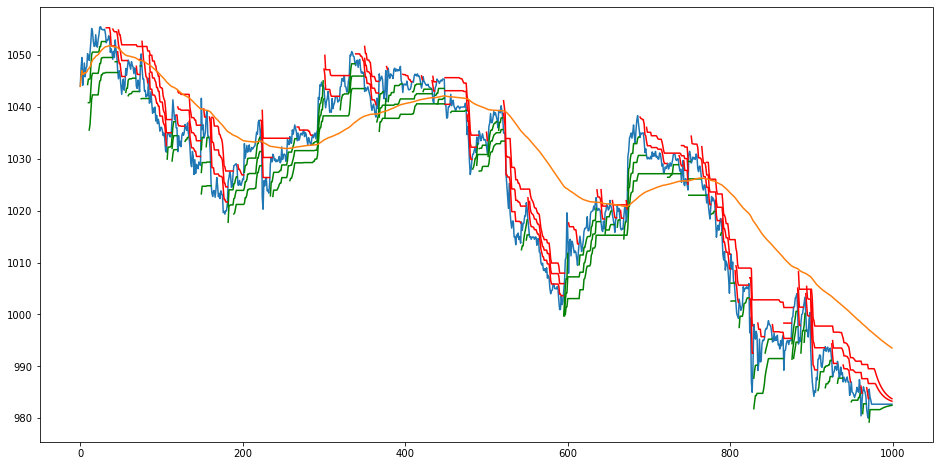

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Buy M&M shares at 1052.55
Sell M&M at 1045.45
Earning from investing 100k is -9.1 (ROI = -0.01%)
p:l(number)=0:1
success % =0.0%
Avg Loss=-7.099999999999909

P/L: -358.84999999999127
Total trades=136
profitable trades: loss trades=27:124
Success %= 17.880794701986755%
Avg win:45.02037037037031
Avg loss:-11.470967741935484


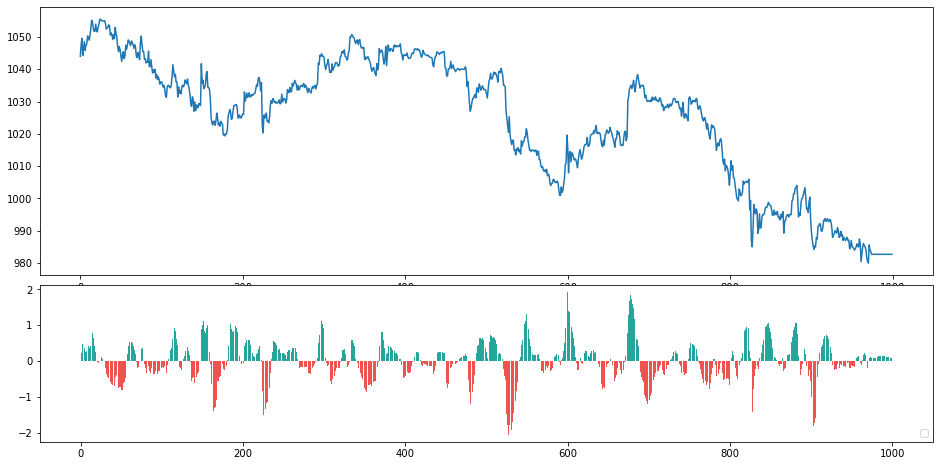

In [36]:
symbol = ['ADANIPORTS', 'APOLLOHOSP', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV', 'BAJFINANCE', 'BPCL',
          'BHARTIARTL', 'BRITANNIA', 'CIPLA', 'COALINDIA', 'DRREDDY', 'DIVISLAB', 'GRASIM'
         , 'HCLTECH', 'HDFC', 'HDFCBANK', 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR', 'ICICIBANK',
          'ITC', 'INDUSINDBK', 'INFY', 'JSWSTEEL', 'KOTAKBANK', 'LT', 'M&M']
print(len(symbol))
ch=0
pn=0
ln=0
p=0
l=0
tr=0
for i in symbol:
    #df = yf.download(i, start='2022-09-09', end='2022-09-10', interval='1m')
    print(i)
    df = pd.read_excel('data5min.xlsx', sheet_name = i).iloc[-1000:].reset_index()

    df3=df
    df4=df
    supertrend = Supertrend(df, 12, 3)
    df = df.join(supertrend)

    supertrend = Supertrend(df3, 11, 2)
    df3 = df3.join(supertrend)

    supertrend = Supertrend(df4, 10, 1)
    df4 = df4.join(supertrend)
    df2 = call(df)
    see(i, df, df2, df3, df4)
    #MACD INDICATOR
    #df['EMA12'] = df['close'].ewm(span=12).mean()
    #df['EMA26'] = df['close'].ewm(span=26).mean()
    #df['MACD'] = df['EMA26'] - df['EMA12']
    #df['MACDSignalLine'] = df['MACD'].ewm(span=9).mean()
    #df['Histogram'] = df['MACD'] - df['MACDSignalLine']
    #macd(df)
    
    googl_macd = get_macd(df['close'], 26, 12, 9)
    googl_macd.tail()
    
    plot_macd(df['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])
    
    #print(googl_macd['hist'])

    c, pn1, ln1, p1, l1, tr1 = backtest_supertrend(df, 100000, i, googl_macd['hist'])
    ch=ch+c
    pn=pn+pn1
    ln=ln+ln1
    p=p+p1
    l=l+l1
    tr=tr+tr1
print(f'\nP/L: {ch}')
print(f'Total trades={tr}')
print(f'profitable trades: loss trades={pn}:{ln}')
if(ln+pn>0):
    print(f'Success %= {pn/(ln+pn)*100}%')
    print(f'Avg win:{p/pn}')
    print(f'Avg loss:{l/ln}')
    

In [31]:
%%time
pd.read_excel('data5min.xlsx', sheet_name = 'ADANIPORTS', skiprows = 82000)

CPU times: total: 16.8 s
Wall time: 16.9 s


81999 2022-06-08 11:50:00  732.85  733.25  732.45   732.8  53640
0    82000 2022-06-08 11:55:00  732.70  733.00  731.80  732.30  14360
1    82001 2022-06-08 12:00:00  732.30  733.10  731.40  732.85  16119
2    82002 2022-06-08 12:05:00  732.90  733.90  732.70  733.35  18547
3    82003 2022-06-08 12:10:00  733.35  733.40  731.40  732.45  14872
4    82004 2022-06-08 12:15:00  732.45  732.75  732.10  732.45   7107
..     ...                 ...     ...     ...     ...     ...    ...
664  82664 2022-06-20 17:15:00  663.15  663.15  663.15  663.15      0
665  82665 2022-06-20 17:20:00  663.15  663.15  663.15  663.15      0
666  82666 2022-06-20 17:30:00  663.15  663.15  663.15  663.15      0
667  82667 2022-06-20 18:15:00  663.15  663.15  663.15  663.15      0
668  82668 2022-06-20 18:50:00  663.15  663.15  663.15  663.15      0

[669 rows x 7 columns]

In [32]:
%%time
pd.read_excel('data5min.xlsx', sheet_name = 'ADANIPORTS')

CPU times: total: 17.3 s
Wall time: 17.4 s


Unnamed: 0                date    open    high     low   close  volume
0               0 2018-01-01 09:15:00  407.00  407.00  403.30  404.55   43220
1               1 2018-01-01 09:20:00  404.60  404.90  404.30  404.80    9068
2               2 2018-01-01 09:25:00  404.80  405.35  404.35  404.35    7767
3               3 2018-01-01 09:30:00  404.50  404.50  403.50  403.55   11129
4               4 2018-01-01 09:35:00  403.55  404.05  403.50  404.05    7058
...           ...                 ...     ...     ...     ...     ...     ...
82664       82664 2022-06-20 17:15:00  663.15  663.15  663.15  663.15       0
82665       82665 2022-06-20 17:20:00  663.15  663.15  663.15  663.15       0
82666       82666 2022-06-20 17:30:00  663.15  663.15  663.15  663.15       0
82667       82667 2022-06-20 18:15:00  663.15  663.15  663.15  663.15       0
82668       82668 2022-06-20 18:50:00  663.15  663.15  663.15  663.15       0

[82669 rows x 7 columns]

In [ ]:
for i in 